In [1]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("glock", {}, "/home/m/glock/glock_person_anns/train.json", "/home/m/glock/glock_person_imgs")
register_coco_instances("glock_test", {}, "/home/m/glock/annotations_glock/test.json", "/home/m/glock/test")
#register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [2]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
#MetadataCatalog.get("glock").thing_classes = ["glock", 'date', 'fig', 'hazelnut']
#MetadataCatalog.get("glock_test").thing_classes = ["glock", 'date', 'fig', 'hazelnut']
#MetadataCatalog.get("fruit_nuts").thing_classes = ["glock", 'date', 'fig', 'hazelnut']

In [3]:
dataset_dicts = DatasetCatalog.get("glock")
glock_metadata = MetadataCatalog.get("glock")

In [4]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

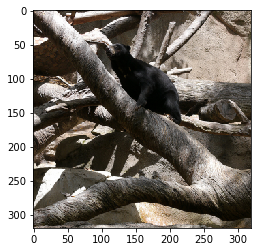

In [5]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glock_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [6]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [7]:
from datetime import datetime
import os

In [8]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"./tboard_logs/glock_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("glock",)
cfg.DATASETS.TEST = ("glock_test",)

cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"
'''
cfg.INPUT.MIN_SIZE_TRAIN = (256,)
cfg.INPUT.MIN_SIZE_TEST = (256,)
cfg.INPUT.MAX_SIZE_TRAIN = (1200,)
cfg.INPUT.MAX_SIZE_TEST = (1200,)
'''
cfg.MODEL.META_ARCHITECTURE = 'RetinaNet'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.MODEL.BACKBONE.FREEZE_AT=3
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR = 0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 100000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS = 1_000
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (100_000, 200_000, 300_000, 400_000, 500_000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 1_000 # 5000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

Loading config /home/m/.local/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [14]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/29 11:11:08 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[09/29 11:11:08 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/29 11:11:14 d2.data.datasets.coco]: Loading /home/m/glock/glock_person_anns/train.json takes 5.63 seconds.
[09/29 11:11:15 d2.data.datasets.coco]: Loaded 122176 images in COCO format from /home/m/glock/glock_person_anns/train.json
[09/29 11:11:18 d2.data.build]: Removed 54172 images with no usable annotations. 68004 images left.
[09/29 11:11:20 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   person   | 257253       |   glock    | 3889         |
|            |              |            |              |
|   total    | 261142       |            |              |
[09/29 11:11:20 d2.data.common]: Serializing 68004 elements to byte tensors and concatenating the

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (18, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.


[09/29 11:11:26 d2.engine.train_loop]: Starting training from iteration 0
[09/29 11:11:30 d2.utils.events]:  eta: 5:33:16  iter: 19  total_loss: 1.303  loss_cls: 1.150  loss_box_reg: 0.200  time: 0.2017  data_time: 0.0119  lr: 0.000020  max_mem: 1833M
[09/29 11:11:35 d2.utils.events]:  eta: 5:40:40  iter: 39  total_loss: 1.026  loss_cls: 0.900  loss_box_reg: 0.153  time: 0.2111  data_time: 0.0160  lr: 0.000040  max_mem: 1833M
[09/29 11:11:39 d2.utils.events]:  eta: 5:50:51  iter: 59  total_loss: 0.763  loss_cls: 0.632  loss_box_reg: 0.141  time: 0.2102  data_time: 0.0032  lr: 0.000060  max_mem: 1842M
[09/29 11:11:43 d2.utils.events]:  eta: 5:43:52  iter: 79  total_loss: 0.715  loss_cls: 0.634  loss_box_reg: 0.141  time: 0.2084  data_time: 0.0032  lr: 0.000080  max_mem: 1889M
[09/29 11:11:47 d2.utils.events]:  eta: 5:41:44  iter: 99  total_loss: 0.605  loss_cls: 0.482  loss_box_reg: 0.130  time: 0.2072  data_time: 0.0035  lr: 0.000100  max_mem: 1889M
[09/29 11:11:52 d2.utils.events]:  e

[09/29 11:14:32 d2.utils.events]:  eta: 5:40:04  iter: 899  total_loss: 0.311  loss_cls: 0.170  loss_box_reg: 0.137  time: 0.2059  data_time: 0.0036  lr: 0.000899  max_mem: 1889M
[09/29 11:14:36 d2.utils.events]:  eta: 5:40:15  iter: 919  total_loss: 0.214  loss_cls: 0.084  loss_box_reg: 0.132  time: 0.2059  data_time: 0.0030  lr: 0.000919  max_mem: 1889M
[09/29 11:14:41 d2.utils.events]:  eta: 5:40:53  iter: 939  total_loss: 0.126  loss_cls: 0.061  loss_box_reg: 0.070  time: 0.2060  data_time: 0.0032  lr: 0.000939  max_mem: 1889M
[09/29 11:14:45 d2.utils.events]:  eta: 5:40:25  iter: 959  total_loss: 0.273  loss_cls: 0.120  loss_box_reg: 0.142  time: 0.2059  data_time: 0.0032  lr: 0.000959  max_mem: 1889M
[09/29 11:14:49 d2.utils.events]:  eta: 5:39:50  iter: 979  total_loss: 0.189  loss_cls: 0.083  loss_box_reg: 0.100  time: 0.2058  data_time: 0.0029  lr: 0.000979  max_mem: 1889M
[09/29 11:14:53 d2.data.datasets.coco]: Loaded 10 images in COCO format from /home/m/glock/annotations_gl

[09/29 11:16:16 d2.utils.events]:  eta: 5:39:02  iter: 1399  total_loss: 0.354  loss_cls: 0.178  loss_box_reg: 0.160  time: 0.2056  data_time: 0.0036  lr: 0.001000  max_mem: 1889M
[09/29 11:16:20 d2.utils.events]:  eta: 5:38:45  iter: 1419  total_loss: 0.213  loss_cls: 0.087  loss_box_reg: 0.122  time: 0.2055  data_time: 0.0031  lr: 0.001000  max_mem: 1889M
[09/29 11:16:24 d2.utils.events]:  eta: 5:38:06  iter: 1439  total_loss: 0.298  loss_cls: 0.133  loss_box_reg: 0.151  time: 0.2054  data_time: 0.0034  lr: 0.001000  max_mem: 1889M
[09/29 11:16:28 d2.utils.events]:  eta: 5:38:20  iter: 1459  total_loss: 0.383  loss_cls: 0.154  loss_box_reg: 0.219  time: 0.2055  data_time: 0.0035  lr: 0.001000  max_mem: 1889M
[09/29 11:16:32 d2.utils.events]:  eta: 5:38:16  iter: 1479  total_loss: 0.211  loss_cls: 0.113  loss_box_reg: 0.124  time: 0.2055  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 11:16:36 d2.utils.events]:  eta: 5:39:05  iter: 1499  total_loss: 0.287  loss_cls: 0.095  los

[09/29 11:18:21 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 26.041 |
[09/29 11:18:21 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:18:21 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:18:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:18:21 d2.evaluation.testing]: copypaste: 26.0408,50.6365,14.1914,nan,0.0000,29.0135
[09/29 11:18:21 d2.utils.events]:  eta: 5:38:07  iter: 1999  total_loss: 0.174  loss_cls: 0.073  loss_box_reg: 0.104  time: 0.2062  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 11:18:25 d2.utils.events]:  eta: 5:37:31  iter: 2019  total_loss: 0.284  loss_cls: 0.137  loss_box_reg: 0.148  time: 0.2061  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:18:30 d2.utils.events]:  eta: 5:37:16  iter: 2039  total_loss: 0.371  loss_cls: 0.157  loss_box_reg: 0.201  t

[09/29 11:21:10 d2.utils.events]:  eta: 5:33:34  iter: 2819  total_loss: 0.292  loss_cls: 0.122  loss_box_reg: 0.170  time: 0.2059  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:21:14 d2.utils.events]:  eta: 5:33:34  iter: 2839  total_loss: 0.234  loss_cls: 0.112  loss_box_reg: 0.145  time: 0.2060  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:21:18 d2.utils.events]:  eta: 5:32:39  iter: 2859  total_loss: 0.405  loss_cls: 0.152  loss_box_reg: 0.226  time: 0.2059  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:21:23 d2.utils.events]:  eta: 5:32:47  iter: 2879  total_loss: 0.272  loss_cls: 0.100  loss_box_reg: 0.159  time: 0.2059  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 11:21:27 d2.utils.events]:  eta: 5:32:31  iter: 2899  total_loss: 0.213  loss_cls: 0.095  loss_box_reg: 0.128  time: 0.2060  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:21:31 d2.utils.events]:  eta: 5:31:47  iter: 2919  total_loss: 0.270  loss_cls: 0.094  los

[09/29 11:23:02 d2.utils.events]:  eta: 5:32:37  iter: 3359  total_loss: 0.234  loss_cls: 0.104  loss_box_reg: 0.135  time: 0.2058  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:23:06 d2.utils.events]:  eta: 5:32:36  iter: 3379  total_loss: 0.303  loss_cls: 0.136  loss_box_reg: 0.155  time: 0.2058  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:23:10 d2.utils.events]:  eta: 5:32:44  iter: 3399  total_loss: 0.205  loss_cls: 0.072  loss_box_reg: 0.122  time: 0.2058  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:23:14 d2.utils.events]:  eta: 5:32:40  iter: 3419  total_loss: 0.343  loss_cls: 0.120  loss_box_reg: 0.217  time: 0.2057  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 11:23:18 d2.utils.events]:  eta: 5:32:28  iter: 3439  total_loss: 0.364  loss_cls: 0.145  loss_box_reg: 0.222  time: 0.2058  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:23:22 d2.utils.events]:  eta: 5:32:27  iter: 3459  total_loss: 0.201  loss_cls: 0.078  los

[09/29 11:25:14 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 11:25:14 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 27.146 |
[09/29 11:25:14 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:25:14 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:25:14 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:25:14 d2.evaluation.testing]: copypaste: 27.1455,52.1099,15.0038,nan,0.0000,31.1779
[09/29 11:25:14 d2.utils.events]:  eta: 5:29:05  iter: 3999  total_loss: 0.196  loss_cls: 0.082  loss_box_reg: 0.108  time: 0.2057  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:25:19 d2.utils.events]:  eta: 5:29:53  iter: 4019  total_loss: 0.266  loss_cls: 0.117  loss_box_reg: 0.142  time: 0.2057  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:25:23 d2

[09/29 11:27:59 d2.utils.events]:  eta: 5:26:34  iter: 4799  total_loss: 0.326  loss_cls: 0.116  loss_box_reg: 0.225  time: 0.2057  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 11:28:03 d2.utils.events]:  eta: 5:26:22  iter: 4819  total_loss: 0.209  loss_cls: 0.077  loss_box_reg: 0.131  time: 0.2057  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:28:07 d2.utils.events]:  eta: 5:26:12  iter: 4839  total_loss: 0.319  loss_cls: 0.127  loss_box_reg: 0.192  time: 0.2056  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 11:28:12 d2.utils.events]:  eta: 5:26:38  iter: 4859  total_loss: 0.303  loss_cls: 0.108  loss_box_reg: 0.172  time: 0.2056  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 11:28:16 d2.utils.events]:  eta: 5:26:23  iter: 4879  total_loss: 0.296  loss_cls: 0.114  loss_box_reg: 0.167  time: 0.2057  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:28:20 d2.utils.events]:  eta: 5:26:03  iter: 4899  total_loss: 0.129  loss_cls: 0.056  los

[09/29 11:29:52 d2.utils.events]:  eta: 5:24:49  iter: 5339  total_loss: 0.294  loss_cls: 0.118  loss_box_reg: 0.150  time: 0.2058  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:29:56 d2.utils.events]:  eta: 5:24:51  iter: 5359  total_loss: 0.330  loss_cls: 0.124  loss_box_reg: 0.198  time: 0.2058  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:30:00 d2.utils.events]:  eta: 5:24:46  iter: 5379  total_loss: 0.212  loss_cls: 0.107  loss_box_reg: 0.093  time: 0.2058  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:30:04 d2.utils.events]:  eta: 5:25:07  iter: 5399  total_loss: 0.219  loss_cls: 0.081  loss_box_reg: 0.139  time: 0.2057  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:30:08 d2.utils.events]:  eta: 5:25:38  iter: 5419  total_loss: 0.243  loss_cls: 0.089  loss_box_reg: 0.143  time: 0.2058  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:30:12 d2.utils.events]:  eta: 5:25:43  iter: 5439  total_loss: 0.430  loss_cls: 0.170  los

[09/29 11:32:08 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 11:32:08 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.577 |
[09/29 11:32:08 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:32:08 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:32:08 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:32:08 d2.evaluation.testing]: copypaste: 20.5769,45.7730,10.3960,nan,0.0000,22.6865
[09/29 11:32:08 d2.utils.events]:  eta: 5:22:42  iter: 5999  total_loss: 0.238  loss_cls: 0.106  loss_box_reg: 0.127  time: 0.2056  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 11:32:12 d2.utils.events]:  eta: 5:22:28  iter: 6019  total_loss: 0.225  loss_cls: 0.088  loss_box_reg: 0.142  time: 0.2056  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:32:16 d2

[09/29 11:34:53 d2.utils.events]:  eta: 5:21:16  iter: 6799  total_loss: 0.290  loss_cls: 0.110  loss_box_reg: 0.165  time: 0.2056  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:34:57 d2.utils.events]:  eta: 5:21:07  iter: 6819  total_loss: 0.314  loss_cls: 0.127  loss_box_reg: 0.179  time: 0.2056  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:35:01 d2.utils.events]:  eta: 5:20:58  iter: 6839  total_loss: 0.349  loss_cls: 0.143  loss_box_reg: 0.206  time: 0.2056  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 11:35:05 d2.utils.events]:  eta: 5:20:59  iter: 6859  total_loss: 0.318  loss_cls: 0.127  loss_box_reg: 0.194  time: 0.2056  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 11:35:09 d2.utils.events]:  eta: 5:20:55  iter: 6879  total_loss: 0.189  loss_cls: 0.060  loss_box_reg: 0.133  time: 0.2056  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:35:13 d2.utils.events]:  eta: 5:20:18  iter: 6899  total_loss: 0.219  loss_cls: 0.091  los

[09/29 11:36:44 d2.utils.events]:  eta: 5:18:56  iter: 7339  total_loss: 0.211  loss_cls: 0.093  loss_box_reg: 0.125  time: 0.2056  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:36:49 d2.utils.events]:  eta: 5:19:05  iter: 7359  total_loss: 0.221  loss_cls: 0.090  loss_box_reg: 0.134  time: 0.2056  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:36:53 d2.utils.events]:  eta: 5:19:09  iter: 7379  total_loss: 0.293  loss_cls: 0.116  loss_box_reg: 0.183  time: 0.2056  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:36:57 d2.utils.events]:  eta: 5:18:46  iter: 7399  total_loss: 0.356  loss_cls: 0.147  loss_box_reg: 0.208  time: 0.2056  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 11:37:01 d2.utils.events]:  eta: 5:18:42  iter: 7419  total_loss: 0.330  loss_cls: 0.136  loss_box_reg: 0.172  time: 0.2055  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:37:05 d2.utils.events]:  eta: 5:18:38  iter: 7439  total_loss: 0.140  loss_cls: 0.070  los

[09/29 11:39:00 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 11:39:00 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 25.535 |
[09/29 11:39:00 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:39:00 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:39:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:39:00 d2.evaluation.testing]: copypaste: 25.5350,49.2574,13.8614,nan,0.0000,28.0470
[09/29 11:39:00 d2.utils.events]:  eta: 5:13:53  iter: 7999  total_loss: 0.210  loss_cls: 0.099  loss_box_reg: 0.112  time: 0.2054  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:39:04 d2.utils.events]:  eta: 5:13:44  iter: 8019  total_loss: 0.357  loss_cls: 0.137  loss_box_reg: 0.198  time: 0.2054  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:39:08 d2

[09/29 11:41:44 d2.utils.events]:  eta: 5:11:12  iter: 8799  total_loss: 0.192  loss_cls: 0.094  loss_box_reg: 0.105  time: 0.2053  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 11:41:48 d2.utils.events]:  eta: 5:11:09  iter: 8819  total_loss: 0.381  loss_cls: 0.158  loss_box_reg: 0.219  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:41:52 d2.utils.events]:  eta: 5:11:12  iter: 8839  total_loss: 0.169  loss_cls: 0.054  loss_box_reg: 0.099  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:41:56 d2.utils.events]:  eta: 5:11:03  iter: 8859  total_loss: 0.242  loss_cls: 0.095  loss_box_reg: 0.144  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:42:00 d2.utils.events]:  eta: 5:10:35  iter: 8879  total_loss: 0.201  loss_cls: 0.062  loss_box_reg: 0.141  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:42:05 d2.utils.events]:  eta: 5:11:06  iter: 8899  total_loss: 0.257  loss_cls: 0.094  los

[09/29 11:43:35 d2.utils.events]:  eta: 5:08:22  iter: 9339  total_loss: 0.222  loss_cls: 0.085  loss_box_reg: 0.135  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:43:39 d2.utils.events]:  eta: 5:08:08  iter: 9359  total_loss: 0.375  loss_cls: 0.141  loss_box_reg: 0.234  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:43:43 d2.utils.events]:  eta: 5:07:50  iter: 9379  total_loss: 0.243  loss_cls: 0.110  loss_box_reg: 0.131  time: 0.2052  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 11:43:48 d2.utils.events]:  eta: 5:07:58  iter: 9399  total_loss: 0.351  loss_cls: 0.135  loss_box_reg: 0.218  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:43:51 d2.utils.events]:  eta: 5:07:33  iter: 9419  total_loss: 0.247  loss_cls: 0.097  loss_box_reg: 0.140  time: 0.2052  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:43:55 d2.utils.events]:  eta: 5:06:55  iter: 9439  total_loss: 0.311  loss_cls: 0.130  los

[09/29 11:45:53 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 11:45:53 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 22.706 |
[09/29 11:45:53 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:45:53 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:45:53 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:45:53 d2.evaluation.testing]: copypaste: 22.7063,47.1947,13.8614,nan,0.0000,24.9010
[09/29 11:45:53 d2.utils.events]:  eta: 5:08:47  iter: 9999  total_loss: 0.470  loss_cls: 0.150  loss_box_reg: 0.281  time: 0.2053  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:45:57 d2.utils.events]:  eta: 5:09:03  iter: 10019  total_loss: 0.209  loss_cls: 0.094  loss_box_reg: 0.104  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:46:02 d

[09/29 11:48:39 d2.utils.events]:  eta: 5:08:16  iter: 10799  total_loss: 0.212  loss_cls: 0.071  loss_box_reg: 0.136  time: 0.2054  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:48:43 d2.utils.events]:  eta: 5:08:14  iter: 10819  total_loss: 0.319  loss_cls: 0.143  loss_box_reg: 0.169  time: 0.2054  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:48:47 d2.utils.events]:  eta: 5:08:09  iter: 10839  total_loss: 0.245  loss_cls: 0.096  loss_box_reg: 0.127  time: 0.2054  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:48:51 d2.utils.events]:  eta: 5:08:04  iter: 10859  total_loss: 0.442  loss_cls: 0.190  loss_box_reg: 0.224  time: 0.2054  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 11:48:55 d2.utils.events]:  eta: 5:08:04  iter: 10879  total_loss: 0.243  loss_cls: 0.103  loss_box_reg: 0.141  time: 0.2054  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 11:48:59 d2.utils.events]:  eta: 5:07:50  iter: 10899  total_loss: 0.142  loss_cls: 0.06

[09/29 11:50:30 d2.utils.events]:  eta: 5:01:44  iter: 11339  total_loss: 0.356  loss_cls: 0.126  loss_box_reg: 0.226  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:50:34 d2.utils.events]:  eta: 5:01:40  iter: 11359  total_loss: 0.197  loss_cls: 0.067  loss_box_reg: 0.139  time: 0.2053  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:50:38 d2.utils.events]:  eta: 5:01:47  iter: 11379  total_loss: 0.220  loss_cls: 0.110  loss_box_reg: 0.119  time: 0.2053  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 11:50:42 d2.utils.events]:  eta: 5:01:43  iter: 11399  total_loss: 0.328  loss_cls: 0.113  loss_box_reg: 0.198  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:50:46 d2.utils.events]:  eta: 5:01:56  iter: 11419  total_loss: 0.266  loss_cls: 0.104  loss_box_reg: 0.151  time: 0.2053  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:50:50 d2.utils.events]:  eta: 5:01:37  iter: 11439  total_loss: 0.409  loss_cls: 0.14

[09/29 11:52:47 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 11:52:47 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 21.026 |
[09/29 11:52:47 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:52:47 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:52:47 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:52:47 d2.evaluation.testing]: copypaste: 21.0262,48.9156,11.4961,nan,0.0000,23.4838
[09/29 11:52:47 d2.utils.events]:  eta: 5:01:48  iter: 11999  total_loss: 0.165  loss_cls: 0.077  loss_box_reg: 0.116  time: 0.2054  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:52:51 d2.utils.events]:  eta: 5:02:19  iter: 12019  total_loss: 0.157  loss_cls: 0.057  loss_box_reg: 0.100  time: 0.2054  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:52:55 

[09/29 11:55:31 d2.utils.events]:  eta: 4:57:41  iter: 12799  total_loss: 0.375  loss_cls: 0.153  loss_box_reg: 0.194  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:55:35 d2.utils.events]:  eta: 4:57:33  iter: 12819  total_loss: 0.293  loss_cls: 0.120  loss_box_reg: 0.193  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:55:39 d2.utils.events]:  eta: 4:57:21  iter: 12839  total_loss: 0.185  loss_cls: 0.082  loss_box_reg: 0.098  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:55:43 d2.utils.events]:  eta: 4:57:22  iter: 12859  total_loss: 0.246  loss_cls: 0.090  loss_box_reg: 0.163  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:55:47 d2.utils.events]:  eta: 4:56:50  iter: 12879  total_loss: 0.207  loss_cls: 0.080  loss_box_reg: 0.080  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 11:55:51 d2.utils.events]:  eta: 4:56:34  iter: 12899  total_loss: 0.132  loss_cls: 0.05

[09/29 11:57:22 d2.utils.events]:  eta: 4:56:30  iter: 13339  total_loss: 0.299  loss_cls: 0.117  loss_box_reg: 0.166  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:57:26 d2.utils.events]:  eta: 4:56:17  iter: 13359  total_loss: 0.283  loss_cls: 0.103  loss_box_reg: 0.185  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:57:30 d2.utils.events]:  eta: 4:56:26  iter: 13379  total_loss: 0.207  loss_cls: 0.091  loss_box_reg: 0.126  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:57:35 d2.utils.events]:  eta: 4:56:52  iter: 13399  total_loss: 0.249  loss_cls: 0.094  loss_box_reg: 0.173  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 11:57:38 d2.utils.events]:  eta: 4:56:33  iter: 13419  total_loss: 0.244  loss_cls: 0.085  loss_box_reg: 0.137  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 11:57:42 d2.utils.events]:  eta: 4:56:29  iter: 13439  total_loss: 0.267  loss_cls: 0.10

[09/29 11:59:39 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 11:59:39 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 26.899 |
[09/29 11:59:39 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 11:59:39 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 11:59:39 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 11:59:39 d2.evaluation.testing]: copypaste: 26.8988,54.9296,16.1245,nan,0.0000,30.7233
[09/29 11:59:39 d2.utils.events]:  eta: 4:54:38  iter: 13999  total_loss: 0.284  loss_cls: 0.116  loss_box_reg: 0.160  time: 0.2052  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:59:43 d2.utils.events]:  eta: 4:54:35  iter: 14019  total_loss: 0.187  loss_cls: 0.089  loss_box_reg: 0.124  time: 0.2052  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 11:59:47 

[09/29 12:02:23 d2.utils.events]:  eta: 4:51:24  iter: 14799  total_loss: 0.292  loss_cls: 0.136  loss_box_reg: 0.179  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:02:28 d2.utils.events]:  eta: 4:51:52  iter: 14819  total_loss: 0.169  loss_cls: 0.072  loss_box_reg: 0.097  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:02:32 d2.utils.events]:  eta: 4:51:43  iter: 14839  total_loss: 0.196  loss_cls: 0.066  loss_box_reg: 0.126  time: 0.2053  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:02:36 d2.utils.events]:  eta: 4:51:29  iter: 14859  total_loss: 0.371  loss_cls: 0.137  loss_box_reg: 0.186  time: 0.2053  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:02:40 d2.utils.events]:  eta: 4:51:44  iter: 14879  total_loss: 0.357  loss_cls: 0.192  loss_box_reg: 0.203  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:02:44 d2.utils.events]:  eta: 4:51:43  iter: 14899  total_loss: 0.198  loss_cls: 0.09

[09/29 12:04:16 d2.utils.events]:  eta: 4:51:41  iter: 15339  total_loss: 0.181  loss_cls: 0.070  loss_box_reg: 0.102  time: 0.2053  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:04:20 d2.utils.events]:  eta: 4:51:57  iter: 15359  total_loss: 0.367  loss_cls: 0.121  loss_box_reg: 0.241  time: 0.2053  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:04:24 d2.utils.events]:  eta: 4:51:42  iter: 15379  total_loss: 0.167  loss_cls: 0.055  loss_box_reg: 0.079  time: 0.2053  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:04:28 d2.utils.events]:  eta: 4:51:16  iter: 15399  total_loss: 0.237  loss_cls: 0.104  loss_box_reg: 0.148  time: 0.2053  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:04:33 d2.utils.events]:  eta: 4:51:03  iter: 15419  total_loss: 0.243  loss_cls: 0.092  loss_box_reg: 0.149  time: 0.2053  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:04:37 d2.utils.events]:  eta: 4:51:08  iter: 15439  total_loss: 0.246  loss_cls: 0.10

[09/29 12:06:32 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:06:32 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 27.457 |
[09/29 12:06:32 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:06:32 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:06:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:06:32 d2.evaluation.testing]: copypaste: 27.4567,56.0437,15.7178,nan,0.0000,30.9150
[09/29 12:06:32 d2.utils.events]:  eta: 4:48:41  iter: 15999  total_loss: 0.178  loss_cls: 0.084  loss_box_reg: 0.101  time: 0.2053  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:06:37 d2.utils.events]:  eta: 4:49:23  iter: 16019  total_loss: 0.226  loss_cls: 0.114  loss_box_reg: 0.156  time: 0.2053  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:06:41 

[09/29 12:09:16 d2.utils.events]:  eta: 4:43:54  iter: 16799  total_loss: 0.256  loss_cls: 0.124  loss_box_reg: 0.136  time: 0.2052  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:09:20 d2.utils.events]:  eta: 4:43:57  iter: 16819  total_loss: 0.241  loss_cls: 0.107  loss_box_reg: 0.144  time: 0.2052  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:09:24 d2.utils.events]:  eta: 4:43:36  iter: 16839  total_loss: 0.146  loss_cls: 0.074  loss_box_reg: 0.072  time: 0.2052  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:09:29 d2.utils.events]:  eta: 4:43:39  iter: 16859  total_loss: 0.213  loss_cls: 0.102  loss_box_reg: 0.114  time: 0.2052  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 12:09:33 d2.utils.events]:  eta: 4:43:20  iter: 16879  total_loss: 0.306  loss_cls: 0.118  loss_box_reg: 0.202  time: 0.2052  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 12:09:37 d2.utils.events]:  eta: 4:43:06  iter: 16899  total_loss: 0.223  loss_cls: 0.08

[09/29 12:11:08 d2.utils.events]:  eta: 4:42:43  iter: 17339  total_loss: 0.154  loss_cls: 0.064  loss_box_reg: 0.108  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:11:12 d2.utils.events]:  eta: 4:42:55  iter: 17359  total_loss: 0.192  loss_cls: 0.070  loss_box_reg: 0.123  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:11:16 d2.utils.events]:  eta: 4:42:35  iter: 17379  total_loss: 0.151  loss_cls: 0.067  loss_box_reg: 0.103  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:11:20 d2.utils.events]:  eta: 4:42:47  iter: 17399  total_loss: 0.259  loss_cls: 0.102  loss_box_reg: 0.158  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:11:24 d2.utils.events]:  eta: 4:42:38  iter: 17419  total_loss: 0.326  loss_cls: 0.152  loss_box_reg: 0.180  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:11:28 d2.utils.events]:  eta: 4:42:23  iter: 17439  total_loss: 0.273  loss_cls: 0.11

[09/29 12:13:25 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:13:25 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 30.857 |
[09/29 12:13:25 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:13:25 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:13:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:13:25 d2.evaluation.testing]: copypaste: 30.8566,53.3303,20.7921,nan,0.0000,34.0264
[09/29 12:13:25 d2.utils.events]:  eta: 4:42:24  iter: 17999  total_loss: 0.213  loss_cls: 0.065  loss_box_reg: 0.147  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:13:29 d2.utils.events]:  eta: 4:42:14  iter: 18019  total_loss: 0.273  loss_cls: 0.082  loss_box_reg: 0.172  time: 0.2052  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:13:33 

[09/29 12:16:08 d2.utils.events]:  eta: 4:36:52  iter: 18799  total_loss: 0.204  loss_cls: 0.076  loss_box_reg: 0.107  time: 0.2052  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:16:12 d2.utils.events]:  eta: 4:36:36  iter: 18819  total_loss: 0.202  loss_cls: 0.096  loss_box_reg: 0.106  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:16:16 d2.utils.events]:  eta: 4:36:40  iter: 18839  total_loss: 0.216  loss_cls: 0.072  loss_box_reg: 0.133  time: 0.2052  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:16:21 d2.utils.events]:  eta: 4:36:40  iter: 18859  total_loss: 0.211  loss_cls: 0.064  loss_box_reg: 0.129  time: 0.2052  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:16:25 d2.utils.events]:  eta: 4:36:48  iter: 18879  total_loss: 0.328  loss_cls: 0.116  loss_box_reg: 0.208  time: 0.2052  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:16:29 d2.utils.events]:  eta: 4:36:44  iter: 18899  total_loss: 0.184  loss_cls: 0.07

[09/29 12:17:59 d2.utils.events]:  eta: 4:33:51  iter: 19339  total_loss: 0.215  loss_cls: 0.093  loss_box_reg: 0.128  time: 0.2051  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:18:03 d2.utils.events]:  eta: 4:34:15  iter: 19359  total_loss: 0.290  loss_cls: 0.128  loss_box_reg: 0.162  time: 0.2051  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:18:08 d2.utils.events]:  eta: 4:34:14  iter: 19379  total_loss: 0.262  loss_cls: 0.092  loss_box_reg: 0.144  time: 0.2051  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:18:11 d2.utils.events]:  eta: 4:33:48  iter: 19399  total_loss: 0.299  loss_cls: 0.139  loss_box_reg: 0.169  time: 0.2051  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:18:16 d2.utils.events]:  eta: 4:34:00  iter: 19419  total_loss: 0.350  loss_cls: 0.136  loss_box_reg: 0.214  time: 0.2051  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:18:20 d2.utils.events]:  eta: 4:34:05  iter: 19439  total_loss: 0.256  loss_cls: 0.09

[09/29 12:20:15 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:20:15 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.684 |
[09/29 12:20:15 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:20:15 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:20:15 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:20:15 d2.evaluation.testing]: copypaste: 20.6841,47.4930,9.4059,nan,0.0000,22.9809
[09/29 12:20:15 d2.utils.events]:  eta: 4:32:00  iter: 19999  total_loss: 0.150  loss_cls: 0.069  loss_box_reg: 0.093  time: 0.2051  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:20:19 d2.utils.events]:  eta: 4:31:51  iter: 20019  total_loss: 0.252  loss_cls: 0.109  loss_box_reg: 0.155  time: 0.2051  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:20:24 d

[09/29 12:22:59 d2.utils.events]:  eta: 4:29:34  iter: 20799  total_loss: 0.273  loss_cls: 0.112  loss_box_reg: 0.161  time: 0.2051  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:23:03 d2.utils.events]:  eta: 4:29:42  iter: 20819  total_loss: 0.264  loss_cls: 0.089  loss_box_reg: 0.172  time: 0.2051  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:23:07 d2.utils.events]:  eta: 4:29:37  iter: 20839  total_loss: 0.273  loss_cls: 0.100  loss_box_reg: 0.180  time: 0.2051  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:23:11 d2.utils.events]:  eta: 4:29:26  iter: 20859  total_loss: 0.299  loss_cls: 0.114  loss_box_reg: 0.211  time: 0.2051  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:23:16 d2.utils.events]:  eta: 4:29:57  iter: 20879  total_loss: 0.275  loss_cls: 0.103  loss_box_reg: 0.164  time: 0.2051  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:23:20 d2.utils.events]:  eta: 4:29:26  iter: 20899  total_loss: 0.266  loss_cls: 0.10

[09/29 12:24:51 d2.utils.events]:  eta: 4:29:39  iter: 21339  total_loss: 0.183  loss_cls: 0.065  loss_box_reg: 0.097  time: 0.2051  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:24:55 d2.utils.events]:  eta: 4:29:06  iter: 21359  total_loss: 0.214  loss_cls: 0.072  loss_box_reg: 0.118  time: 0.2050  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:24:59 d2.utils.events]:  eta: 4:29:14  iter: 21379  total_loss: 0.239  loss_cls: 0.072  loss_box_reg: 0.166  time: 0.2051  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:25:03 d2.utils.events]:  eta: 4:29:17  iter: 21399  total_loss: 0.436  loss_cls: 0.215  loss_box_reg: 0.203  time: 0.2051  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:25:07 d2.utils.events]:  eta: 4:29:06  iter: 21419  total_loss: 0.378  loss_cls: 0.175  loss_box_reg: 0.213  time: 0.2051  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:25:12 d2.utils.events]:  eta: 4:29:02  iter: 21439  total_loss: 0.203  loss_cls: 0.10

[09/29 12:27:07 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:27:07 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.054 |
[09/29 12:27:07 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:27:07 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:27:07 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:27:07 d2.evaluation.testing]: copypaste: 20.0544,37.6836,10.3960,nan,0.0000,22.6568
[09/29 12:27:07 d2.utils.events]:  eta: 4:26:50  iter: 21999  total_loss: 0.246  loss_cls: 0.104  loss_box_reg: 0.144  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:27:11 d2.utils.events]:  eta: 4:26:21  iter: 22019  total_loss: 0.225  loss_cls: 0.081  loss_box_reg: 0.165  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:27:15 

[09/29 12:29:50 d2.utils.events]:  eta: 4:22:25  iter: 22799  total_loss: 0.254  loss_cls: 0.098  loss_box_reg: 0.157  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:29:54 d2.utils.events]:  eta: 4:22:24  iter: 22819  total_loss: 0.138  loss_cls: 0.059  loss_box_reg: 0.073  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:29:58 d2.utils.events]:  eta: 4:21:56  iter: 22839  total_loss: 0.303  loss_cls: 0.117  loss_box_reg: 0.161  time: 0.2050  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:30:02 d2.utils.events]:  eta: 4:22:01  iter: 22859  total_loss: 0.201  loss_cls: 0.075  loss_box_reg: 0.127  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:30:06 d2.utils.events]:  eta: 4:21:41  iter: 22879  total_loss: 0.186  loss_cls: 0.057  loss_box_reg: 0.128  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:30:10 d2.utils.events]:  eta: 4:21:33  iter: 22899  total_loss: 0.360  loss_cls: 0.17

[09/29 12:31:41 d2.utils.events]:  eta: 4:20:52  iter: 23339  total_loss: 0.274  loss_cls: 0.107  loss_box_reg: 0.148  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:31:45 d2.utils.events]:  eta: 4:20:58  iter: 23359  total_loss: 0.145  loss_cls: 0.059  loss_box_reg: 0.085  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:31:49 d2.utils.events]:  eta: 4:20:48  iter: 23379  total_loss: 0.197  loss_cls: 0.071  loss_box_reg: 0.138  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:31:54 d2.utils.events]:  eta: 4:21:00  iter: 23399  total_loss: 0.347  loss_cls: 0.147  loss_box_reg: 0.220  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:31:58 d2.utils.events]:  eta: 4:21:02  iter: 23419  total_loss: 0.234  loss_cls: 0.084  loss_box_reg: 0.146  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:32:02 d2.utils.events]:  eta: 4:20:39  iter: 23439  total_loss: 0.129  loss_cls: 0.04

[09/29 12:33:57 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:33:57 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 22.391 |
[09/29 12:33:57 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:33:57 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:33:57 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:33:57 d2.evaluation.testing]: copypaste: 22.3912,50.4950,13.8614,nan,0.0000,24.5680
[09/29 12:33:57 d2.utils.events]:  eta: 4:19:59  iter: 23999  total_loss: 0.208  loss_cls: 0.085  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:34:01 d2.utils.events]:  eta: 4:20:20  iter: 24019  total_loss: 0.307  loss_cls: 0.105  loss_box_reg: 0.198  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:34:06 

[09/29 12:36:42 d2.utils.events]:  eta: 4:17:53  iter: 24799  total_loss: 0.151  loss_cls: 0.063  loss_box_reg: 0.102  time: 0.2050  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:36:46 d2.utils.events]:  eta: 4:18:03  iter: 24819  total_loss: 0.300  loss_cls: 0.132  loss_box_reg: 0.184  time: 0.2050  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:36:50 d2.utils.events]:  eta: 4:17:36  iter: 24839  total_loss: 0.189  loss_cls: 0.079  loss_box_reg: 0.099  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:36:54 d2.utils.events]:  eta: 4:17:32  iter: 24859  total_loss: 0.228  loss_cls: 0.097  loss_box_reg: 0.146  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:36:59 d2.utils.events]:  eta: 4:17:17  iter: 24879  total_loss: 0.258  loss_cls: 0.093  loss_box_reg: 0.159  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:37:03 d2.utils.events]:  eta: 4:18:02  iter: 24899  total_loss: 0.240  loss_cls: 0.10

[09/29 12:38:33 d2.utils.events]:  eta: 4:15:35  iter: 25339  total_loss: 0.320  loss_cls: 0.124  loss_box_reg: 0.199  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:38:38 d2.utils.events]:  eta: 4:15:53  iter: 25359  total_loss: 0.196  loss_cls: 0.093  loss_box_reg: 0.127  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:38:42 d2.utils.events]:  eta: 4:16:16  iter: 25379  total_loss: 0.244  loss_cls: 0.092  loss_box_reg: 0.151  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:38:46 d2.utils.events]:  eta: 4:16:03  iter: 25399  total_loss: 0.219  loss_cls: 0.065  loss_box_reg: 0.148  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:38:50 d2.utils.events]:  eta: 4:16:04  iter: 25419  total_loss: 0.187  loss_cls: 0.055  loss_box_reg: 0.112  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:38:54 d2.utils.events]:  eta: 4:16:22  iter: 25439  total_loss: 0.233  loss_cls: 0.10

[09/29 12:40:50 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:40:50 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 24.888 |
[09/29 12:40:50 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:40:50 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:40:50 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:40:50 d2.evaluation.testing]: copypaste: 24.8877,48.0515,13.8614,nan,0.0000,27.2972
[09/29 12:40:50 d2.utils.events]:  eta: 4:13:23  iter: 25999  total_loss: 0.405  loss_cls: 0.155  loss_box_reg: 0.208  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:40:54 d2.utils.events]:  eta: 4:13:05  iter: 26019  total_loss: 0.302  loss_cls: 0.124  loss_box_reg: 0.165  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:40:58 

[09/29 12:43:34 d2.utils.events]:  eta: 4:09:26  iter: 26799  total_loss: 0.270  loss_cls: 0.105  loss_box_reg: 0.159  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:43:38 d2.utils.events]:  eta: 4:09:20  iter: 26819  total_loss: 0.206  loss_cls: 0.094  loss_box_reg: 0.139  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:43:42 d2.utils.events]:  eta: 4:09:11  iter: 26839  total_loss: 0.319  loss_cls: 0.146  loss_box_reg: 0.157  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:43:46 d2.utils.events]:  eta: 4:09:22  iter: 26859  total_loss: 0.152  loss_cls: 0.056  loss_box_reg: 0.097  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:43:50 d2.utils.events]:  eta: 4:09:10  iter: 26879  total_loss: 0.397  loss_cls: 0.137  loss_box_reg: 0.233  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:43:54 d2.utils.events]:  eta: 4:09:05  iter: 26899  total_loss: 0.314  loss_cls: 0.14

[09/29 12:45:25 d2.utils.events]:  eta: 4:07:44  iter: 27339  total_loss: 0.226  loss_cls: 0.079  loss_box_reg: 0.156  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:45:29 d2.utils.events]:  eta: 4:07:42  iter: 27359  total_loss: 0.267  loss_cls: 0.127  loss_box_reg: 0.182  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:45:33 d2.utils.events]:  eta: 4:07:40  iter: 27379  total_loss: 0.264  loss_cls: 0.101  loss_box_reg: 0.153  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:45:37 d2.utils.events]:  eta: 4:07:47  iter: 27399  total_loss: 0.221  loss_cls: 0.073  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 12:45:41 d2.utils.events]:  eta: 4:07:35  iter: 27419  total_loss: 0.224  loss_cls: 0.081  loss_box_reg: 0.143  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:45:45 d2.utils.events]:  eta: 4:07:45  iter: 27439  total_loss: 0.247  loss_cls: 0.11

[09/29 12:47:41 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:47:41 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 22.228 |
[09/29 12:47:41 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:47:41 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:47:41 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:47:41 d2.evaluation.testing]: copypaste: 22.2277,53.7954,13.8614,nan,0.0000,24.4180
[09/29 12:47:41 d2.utils.events]:  eta: 4:04:33  iter: 27999  total_loss: 0.206  loss_cls: 0.073  loss_box_reg: 0.133  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:47:44 d2.utils.events]:  eta: 4:04:23  iter: 28019  total_loss: 0.198  loss_cls: 0.072  loss_box_reg: 0.110  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:47:48 

[09/29 12:50:26 d2.utils.events]:  eta: 4:03:12  iter: 28799  total_loss: 0.249  loss_cls: 0.093  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:50:30 d2.utils.events]:  eta: 4:03:00  iter: 28819  total_loss: 0.262  loss_cls: 0.085  loss_box_reg: 0.120  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:50:34 d2.utils.events]:  eta: 4:03:06  iter: 28839  total_loss: 0.243  loss_cls: 0.087  loss_box_reg: 0.157  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:50:38 d2.utils.events]:  eta: 4:02:57  iter: 28859  total_loss: 0.166  loss_cls: 0.061  loss_box_reg: 0.097  time: 0.2049  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 12:50:42 d2.utils.events]:  eta: 4:03:05  iter: 28879  total_loss: 0.215  loss_cls: 0.075  loss_box_reg: 0.136  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:50:46 d2.utils.events]:  eta: 4:03:10  iter: 28899  total_loss: 0.617  loss_cls: 0.26

[09/29 12:52:17 d2.utils.events]:  eta: 4:01:42  iter: 29339  total_loss: 0.200  loss_cls: 0.075  loss_box_reg: 0.128  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:52:21 d2.utils.events]:  eta: 4:01:13  iter: 29359  total_loss: 0.312  loss_cls: 0.141  loss_box_reg: 0.182  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:52:25 d2.utils.events]:  eta: 4:01:03  iter: 29379  total_loss: 0.155  loss_cls: 0.053  loss_box_reg: 0.102  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:52:29 d2.utils.events]:  eta: 4:01:01  iter: 29399  total_loss: 0.278  loss_cls: 0.100  loss_box_reg: 0.154  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 12:52:34 d2.utils.events]:  eta: 4:01:01  iter: 29419  total_loss: 0.170  loss_cls: 0.055  loss_box_reg: 0.105  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 12:52:38 d2.utils.events]:  eta: 4:00:53  iter: 29439  total_loss: 0.316  loss_cls: 0.11

[09/29 12:54:35 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 12:54:35 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.578 |
[09/29 12:54:35 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 12:54:35 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 12:54:35 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 12:54:35 d2.evaluation.testing]: copypaste: 20.5783,44.8470,9.4059,nan,0.0000,22.7601
[09/29 12:54:35 d2.utils.events]:  eta: 4:00:12  iter: 29999  total_loss: 0.255  loss_cls: 0.092  loss_box_reg: 0.165  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:54:39 d2.utils.events]:  eta: 4:00:29  iter: 30019  total_loss: 0.138  loss_cls: 0.062  loss_box_reg: 0.084  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:54:44 d

[09/29 12:57:19 d2.utils.events]:  eta: 3:56:18  iter: 30799  total_loss: 0.194  loss_cls: 0.056  loss_box_reg: 0.132  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:57:24 d2.utils.events]:  eta: 3:56:14  iter: 30819  total_loss: 0.241  loss_cls: 0.084  loss_box_reg: 0.175  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:57:28 d2.utils.events]:  eta: 3:56:26  iter: 30839  total_loss: 0.388  loss_cls: 0.150  loss_box_reg: 0.245  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 12:57:32 d2.utils.events]:  eta: 3:56:22  iter: 30859  total_loss: 0.208  loss_cls: 0.087  loss_box_reg: 0.123  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 12:57:36 d2.utils.events]:  eta: 3:56:23  iter: 30879  total_loss: 0.250  loss_cls: 0.096  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 12:57:40 d2.utils.events]:  eta: 3:56:28  iter: 30899  total_loss: 0.191  loss_cls: 0.08

[09/29 12:59:10 d2.utils.events]:  eta: 3:53:53  iter: 31339  total_loss: 0.276  loss_cls: 0.102  loss_box_reg: 0.181  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 12:59:14 d2.utils.events]:  eta: 3:53:49  iter: 31359  total_loss: 0.217  loss_cls: 0.090  loss_box_reg: 0.124  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:59:18 d2.utils.events]:  eta: 3:53:34  iter: 31379  total_loss: 0.190  loss_cls: 0.066  loss_box_reg: 0.110  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 12:59:22 d2.utils.events]:  eta: 3:53:34  iter: 31399  total_loss: 0.339  loss_cls: 0.126  loss_box_reg: 0.189  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:59:26 d2.utils.events]:  eta: 3:53:10  iter: 31419  total_loss: 0.249  loss_cls: 0.110  loss_box_reg: 0.175  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 12:59:30 d2.utils.events]:  eta: 3:52:59  iter: 31439  total_loss: 0.309  loss_cls: 0.10

[09/29 13:01:26 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:01:26 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 22.776 |
[09/29 13:01:26 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:01:26 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:01:26 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:01:26 d2.evaluation.testing]: copypaste: 22.7763,45.4902,13.8614,nan,0.0000,24.9763
[09/29 13:01:26 d2.utils.events]:  eta: 3:50:28  iter: 31999  total_loss: 0.260  loss_cls: 0.093  loss_box_reg: 0.165  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 13:01:30 d2.utils.events]:  eta: 3:50:52  iter: 32019  total_loss: 0.219  loss_cls: 0.095  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:01:34 

[09/29 13:04:10 d2.utils.events]:  eta: 3:49:22  iter: 32799  total_loss: 0.236  loss_cls: 0.075  loss_box_reg: 0.169  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 13:04:14 d2.utils.events]:  eta: 3:49:15  iter: 32819  total_loss: 0.251  loss_cls: 0.088  loss_box_reg: 0.150  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 13:04:18 d2.utils.events]:  eta: 3:48:51  iter: 32839  total_loss: 0.132  loss_cls: 0.042  loss_box_reg: 0.090  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:04:23 d2.utils.events]:  eta: 3:48:40  iter: 32859  total_loss: 0.347  loss_cls: 0.112  loss_box_reg: 0.174  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 13:04:27 d2.utils.events]:  eta: 3:48:39  iter: 32879  total_loss: 0.329  loss_cls: 0.127  loss_box_reg: 0.206  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:04:31 d2.utils.events]:  eta: 3:48:58  iter: 32899  total_loss: 0.263  loss_cls: 0.09

[09/29 13:06:02 d2.utils.events]:  eta: 3:48:04  iter: 33339  total_loss: 0.368  loss_cls: 0.135  loss_box_reg: 0.245  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:06:06 d2.utils.events]:  eta: 3:47:49  iter: 33359  total_loss: 0.185  loss_cls: 0.080  loss_box_reg: 0.100  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:06:10 d2.utils.events]:  eta: 3:47:50  iter: 33379  total_loss: 0.337  loss_cls: 0.115  loss_box_reg: 0.221  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:06:15 d2.utils.events]:  eta: 3:47:45  iter: 33399  total_loss: 0.193  loss_cls: 0.078  loss_box_reg: 0.115  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:06:19 d2.utils.events]:  eta: 3:47:58  iter: 33419  total_loss: 0.274  loss_cls: 0.115  loss_box_reg: 0.160  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:06:23 d2.utils.events]:  eta: 3:47:23  iter: 33439  total_loss: 0.185  loss_cls: 0.06

[09/29 13:08:18 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:08:18 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 18.350 |
[09/29 13:08:18 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:08:18 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:08:18 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:08:18 d2.evaluation.testing]: copypaste: 18.3499,46.3162,9.4059,nan,0.0000,20.4236
[09/29 13:08:18 d2.utils.events]:  eta: 3:47:27  iter: 33999  total_loss: 0.225  loss_cls: 0.053  loss_box_reg: 0.155  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:08:23 d2.utils.events]:  eta: 3:47:33  iter: 34019  total_loss: 0.224  loss_cls: 0.076  loss_box_reg: 0.137  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 13:08:27 d

[09/29 13:11:02 d2.utils.events]:  eta: 3:44:09  iter: 34799  total_loss: 0.227  loss_cls: 0.096  loss_box_reg: 0.145  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:11:07 d2.utils.events]:  eta: 3:44:07  iter: 34819  total_loss: 0.166  loss_cls: 0.059  loss_box_reg: 0.109  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:11:11 d2.utils.events]:  eta: 3:44:01  iter: 34839  total_loss: 0.206  loss_cls: 0.066  loss_box_reg: 0.142  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:11:15 d2.utils.events]:  eta: 3:43:46  iter: 34859  total_loss: 0.220  loss_cls: 0.082  loss_box_reg: 0.126  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:11:19 d2.utils.events]:  eta: 3:44:15  iter: 34879  total_loss: 0.208  loss_cls: 0.069  loss_box_reg: 0.105  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:11:24 d2.utils.events]:  eta: 3:44:08  iter: 34899  total_loss: 0.260  loss_cls: 0.11

[09/29 13:12:54 d2.utils.events]:  eta: 3:39:38  iter: 35339  total_loss: 0.187  loss_cls: 0.083  loss_box_reg: 0.103  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 13:12:58 d2.utils.events]:  eta: 3:39:32  iter: 35359  total_loss: 0.217  loss_cls: 0.070  loss_box_reg: 0.142  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:13:02 d2.utils.events]:  eta: 3:39:44  iter: 35379  total_loss: 0.174  loss_cls: 0.070  loss_box_reg: 0.105  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:13:06 d2.utils.events]:  eta: 3:39:40  iter: 35399  total_loss: 0.164  loss_cls: 0.062  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:13:10 d2.utils.events]:  eta: 3:39:31  iter: 35419  total_loss: 0.313  loss_cls: 0.114  loss_box_reg: 0.216  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 13:13:14 d2.utils.events]:  eta: 3:39:11  iter: 35439  total_loss: 0.181  loss_cls: 0.05

[09/29 13:15:11 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:15:11 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 23.509 |
[09/29 13:15:11 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:15:11 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:15:11 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:15:11 d2.evaluation.testing]: copypaste: 23.5086,49.8709,14.5071,nan,0.0000,26.2594
[09/29 13:15:11 d2.utils.events]:  eta: 3:39:01  iter: 35999  total_loss: 0.146  loss_cls: 0.044  loss_box_reg: 0.096  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:15:15 d2.utils.events]:  eta: 3:38:51  iter: 36019  total_loss: 0.119  loss_cls: 0.030  loss_box_reg: 0.086  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:15:20 

[09/29 13:17:55 d2.utils.events]:  eta: 3:36:03  iter: 36799  total_loss: 0.227  loss_cls: 0.093  loss_box_reg: 0.137  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:17:59 d2.utils.events]:  eta: 3:35:52  iter: 36819  total_loss: 0.191  loss_cls: 0.050  loss_box_reg: 0.131  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:18:03 d2.utils.events]:  eta: 3:35:51  iter: 36839  total_loss: 0.262  loss_cls: 0.075  loss_box_reg: 0.173  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:18:07 d2.utils.events]:  eta: 3:36:00  iter: 36859  total_loss: 0.175  loss_cls: 0.066  loss_box_reg: 0.109  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:18:11 d2.utils.events]:  eta: 3:35:40  iter: 36879  total_loss: 0.323  loss_cls: 0.117  loss_box_reg: 0.185  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:18:16 d2.utils.events]:  eta: 3:35:52  iter: 36899  total_loss: 0.280  loss_cls: 0.10

[09/29 13:19:47 d2.utils.events]:  eta: 3:34:41  iter: 37339  total_loss: 0.374  loss_cls: 0.156  loss_box_reg: 0.232  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:19:51 d2.utils.events]:  eta: 3:34:38  iter: 37359  total_loss: 0.187  loss_cls: 0.058  loss_box_reg: 0.104  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:19:56 d2.utils.events]:  eta: 3:34:37  iter: 37379  total_loss: 0.265  loss_cls: 0.096  loss_box_reg: 0.174  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:20:00 d2.utils.events]:  eta: 3:34:44  iter: 37399  total_loss: 0.164  loss_cls: 0.070  loss_box_reg: 0.109  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:20:04 d2.utils.events]:  eta: 3:34:32  iter: 37419  total_loss: 0.208  loss_cls: 0.092  loss_box_reg: 0.116  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:20:08 d2.utils.events]:  eta: 3:34:23  iter: 37439  total_loss: 0.306  loss_cls: 0.09

[09/29 13:22:04 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:22:04 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 21.697 |
[09/29 13:22:04 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:22:04 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:22:04 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:22:04 d2.evaluation.testing]: copypaste: 21.6967,44.7645,13.8614,nan,0.0000,24.0223
[09/29 13:22:04 d2.utils.events]:  eta: 3:33:43  iter: 37999  total_loss: 0.185  loss_cls: 0.052  loss_box_reg: 0.119  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:22:09 d2.utils.events]:  eta: 3:33:43  iter: 38019  total_loss: 0.287  loss_cls: 0.100  loss_box_reg: 0.176  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:22:13 

[09/29 13:24:49 d2.utils.events]:  eta: 3:29:45  iter: 38799  total_loss: 0.277  loss_cls: 0.099  loss_box_reg: 0.183  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 13:24:53 d2.utils.events]:  eta: 3:29:44  iter: 38819  total_loss: 0.138  loss_cls: 0.073  loss_box_reg: 0.085  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 13:24:57 d2.utils.events]:  eta: 3:29:34  iter: 38839  total_loss: 0.281  loss_cls: 0.098  loss_box_reg: 0.183  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 13:25:01 d2.utils.events]:  eta: 3:29:11  iter: 38859  total_loss: 0.288  loss_cls: 0.104  loss_box_reg: 0.176  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 13:25:06 d2.utils.events]:  eta: 3:29:29  iter: 38879  total_loss: 0.324  loss_cls: 0.100  loss_box_reg: 0.171  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:25:10 d2.utils.events]:  eta: 3:29:29  iter: 38899  total_loss: 0.205  loss_cls: 0.06

[09/29 13:26:40 d2.utils.events]:  eta: 3:26:21  iter: 39339  total_loss: 0.266  loss_cls: 0.094  loss_box_reg: 0.177  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 13:26:44 d2.utils.events]:  eta: 3:26:02  iter: 39359  total_loss: 0.171  loss_cls: 0.062  loss_box_reg: 0.133  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:26:48 d2.utils.events]:  eta: 3:26:07  iter: 39379  total_loss: 0.162  loss_cls: 0.051  loss_box_reg: 0.104  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 13:26:52 d2.utils.events]:  eta: 3:25:48  iter: 39399  total_loss: 0.254  loss_cls: 0.099  loss_box_reg: 0.141  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:26:56 d2.utils.events]:  eta: 3:25:49  iter: 39419  total_loss: 0.158  loss_cls: 0.058  loss_box_reg: 0.101  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:27:00 d2.utils.events]:  eta: 3:25:43  iter: 39439  total_loss: 0.269  loss_cls: 0.11

[09/29 13:28:57 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:28:57 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 18.850 |
[09/29 13:28:57 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:28:57 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:28:57 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:28:57 d2.evaluation.testing]: copypaste: 18.8503,41.7256,10.3960,nan,0.0000,20.7054
[09/29 13:28:57 d2.utils.events]:  eta: 3:25:37  iter: 39999  total_loss: 0.336  loss_cls: 0.139  loss_box_reg: 0.183  time: 0.2049  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 13:29:01 d2.utils.events]:  eta: 3:25:33  iter: 40019  total_loss: 0.259  loss_cls: 0.085  loss_box_reg: 0.166  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:29:06 

[09/29 13:31:41 d2.utils.events]:  eta: 3:20:29  iter: 40799  total_loss: 0.142  loss_cls: 0.036  loss_box_reg: 0.099  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:31:45 d2.utils.events]:  eta: 3:20:27  iter: 40819  total_loss: 0.229  loss_cls: 0.083  loss_box_reg: 0.157  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:31:49 d2.utils.events]:  eta: 3:20:15  iter: 40839  total_loss: 0.192  loss_cls: 0.071  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 13:31:53 d2.utils.events]:  eta: 3:20:09  iter: 40859  total_loss: 0.231  loss_cls: 0.098  loss_box_reg: 0.131  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:31:57 d2.utils.events]:  eta: 3:20:05  iter: 40879  total_loss: 0.330  loss_cls: 0.126  loss_box_reg: 0.210  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:32:01 d2.utils.events]:  eta: 3:20:03  iter: 40899  total_loss: 0.213  loss_cls: 0.07

[09/29 13:33:32 d2.utils.events]:  eta: 3:19:06  iter: 41339  total_loss: 0.246  loss_cls: 0.103  loss_box_reg: 0.158  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:33:36 d2.utils.events]:  eta: 3:19:01  iter: 41359  total_loss: 0.274  loss_cls: 0.088  loss_box_reg: 0.164  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 13:33:41 d2.utils.events]:  eta: 3:19:05  iter: 41379  total_loss: 0.237  loss_cls: 0.083  loss_box_reg: 0.162  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:33:45 d2.utils.events]:  eta: 3:19:01  iter: 41399  total_loss: 0.216  loss_cls: 0.094  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:33:49 d2.utils.events]:  eta: 3:19:16  iter: 41419  total_loss: 0.314  loss_cls: 0.121  loss_box_reg: 0.177  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:33:53 d2.utils.events]:  eta: 3:19:26  iter: 41439  total_loss: 0.157  loss_cls: 0.05

[09/29 13:35:49 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:35:49 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 18.096 |
[09/29 13:35:49 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:35:49 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:35:49 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:35:49 d2.evaluation.testing]: copypaste: 18.0958,42.4135,10.3960,nan,0.0000,19.9202
[09/29 13:35:49 d2.utils.events]:  eta: 3:19:10  iter: 41999  total_loss: 0.250  loss_cls: 0.112  loss_box_reg: 0.151  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:35:53 d2.utils.events]:  eta: 3:19:05  iter: 42019  total_loss: 0.202  loss_cls: 0.101  loss_box_reg: 0.116  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:35:57 

[09/29 13:38:34 d2.utils.events]:  eta: 3:15:41  iter: 42799  total_loss: 0.119  loss_cls: 0.047  loss_box_reg: 0.078  time: 0.2049  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 13:38:38 d2.utils.events]:  eta: 3:15:40  iter: 42819  total_loss: 0.186  loss_cls: 0.080  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:38:42 d2.utils.events]:  eta: 3:15:41  iter: 42839  total_loss: 0.198  loss_cls: 0.074  loss_box_reg: 0.127  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:38:46 d2.utils.events]:  eta: 3:15:39  iter: 42859  total_loss: 0.203  loss_cls: 0.075  loss_box_reg: 0.121  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:38:50 d2.utils.events]:  eta: 3:15:41  iter: 42879  total_loss: 0.242  loss_cls: 0.103  loss_box_reg: 0.139  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 13:38:54 d2.utils.events]:  eta: 3:15:40  iter: 42899  total_loss: 0.237  loss_cls: 0.09

[09/29 13:40:25 d2.utils.events]:  eta: 3:13:54  iter: 43339  total_loss: 0.238  loss_cls: 0.108  loss_box_reg: 0.147  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:40:29 d2.utils.events]:  eta: 3:13:55  iter: 43359  total_loss: 0.227  loss_cls: 0.111  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:40:33 d2.utils.events]:  eta: 3:13:54  iter: 43379  total_loss: 0.166  loss_cls: 0.074  loss_box_reg: 0.116  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:40:37 d2.utils.events]:  eta: 3:13:40  iter: 43399  total_loss: 0.178  loss_cls: 0.068  loss_box_reg: 0.103  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:40:41 d2.utils.events]:  eta: 3:13:40  iter: 43419  total_loss: 0.201  loss_cls: 0.087  loss_box_reg: 0.109  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:40:46 d2.utils.events]:  eta: 3:13:44  iter: 43439  total_loss: 0.238  loss_cls: 0.07

[09/29 13:42:41 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:42:41 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 23.020 |
[09/29 13:42:41 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:42:41 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:42:41 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:42:41 d2.evaluation.testing]: copypaste: 23.0198,51.3951,13.8614,nan,0.0000,25.2475
[09/29 13:42:41 d2.utils.events]:  eta: 3:11:23  iter: 43999  total_loss: 0.309  loss_cls: 0.118  loss_box_reg: 0.188  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:42:45 d2.utils.events]:  eta: 3:11:15  iter: 44019  total_loss: 0.139  loss_cls: 0.042  loss_box_reg: 0.092  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:42:50 

[09/29 13:45:27 d2.utils.events]:  eta: 3:08:51  iter: 44799  total_loss: 0.291  loss_cls: 0.115  loss_box_reg: 0.178  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:45:31 d2.utils.events]:  eta: 3:08:46  iter: 44819  total_loss: 0.268  loss_cls: 0.102  loss_box_reg: 0.186  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:45:35 d2.utils.events]:  eta: 3:08:41  iter: 44839  total_loss: 0.254  loss_cls: 0.127  loss_box_reg: 0.151  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:45:39 d2.utils.events]:  eta: 3:08:47  iter: 44859  total_loss: 0.231  loss_cls: 0.090  loss_box_reg: 0.138  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:45:43 d2.utils.events]:  eta: 3:08:45  iter: 44879  total_loss: 0.166  loss_cls: 0.047  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:45:47 d2.utils.events]:  eta: 3:08:41  iter: 44899  total_loss: 0.312  loss_cls: 0.12

[09/29 13:47:19 d2.utils.events]:  eta: 3:07:48  iter: 45339  total_loss: 0.165  loss_cls: 0.068  loss_box_reg: 0.103  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:47:23 d2.utils.events]:  eta: 3:07:43  iter: 45359  total_loss: 0.341  loss_cls: 0.141  loss_box_reg: 0.212  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:47:27 d2.utils.events]:  eta: 3:07:44  iter: 45379  total_loss: 0.178  loss_cls: 0.057  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:47:31 d2.utils.events]:  eta: 3:07:49  iter: 45399  total_loss: 0.291  loss_cls: 0.101  loss_box_reg: 0.179  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:47:35 d2.utils.events]:  eta: 3:07:25  iter: 45419  total_loss: 0.377  loss_cls: 0.143  loss_box_reg: 0.205  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:47:39 d2.utils.events]:  eta: 3:07:25  iter: 45439  total_loss: 0.318  loss_cls: 0.13

[09/29 13:49:36 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:49:36 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 21.488 |
[09/29 13:49:36 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:49:36 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:49:36 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:49:36 d2.evaluation.testing]: copypaste: 21.4883,43.5801,13.8614,nan,0.0000,24.2409
[09/29 13:49:36 d2.utils.events]:  eta: 3:06:03  iter: 45999  total_loss: 0.229  loss_cls: 0.087  loss_box_reg: 0.144  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:49:40 d2.utils.events]:  eta: 3:05:54  iter: 46019  total_loss: 0.330  loss_cls: 0.138  loss_box_reg: 0.192  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:49:44 

[09/29 13:52:20 d2.utils.events]:  eta: 3:02:30  iter: 46799  total_loss: 0.165  loss_cls: 0.073  loss_box_reg: 0.097  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:52:24 d2.utils.events]:  eta: 3:02:22  iter: 46819  total_loss: 0.329  loss_cls: 0.108  loss_box_reg: 0.211  time: 0.2049  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 13:52:28 d2.utils.events]:  eta: 3:02:17  iter: 46839  total_loss: 0.257  loss_cls: 0.090  loss_box_reg: 0.167  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:52:32 d2.utils.events]:  eta: 3:02:14  iter: 46859  total_loss: 0.251  loss_cls: 0.072  loss_box_reg: 0.165  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:52:36 d2.utils.events]:  eta: 3:02:00  iter: 46879  total_loss: 0.283  loss_cls: 0.127  loss_box_reg: 0.171  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:52:40 d2.utils.events]:  eta: 3:01:44  iter: 46899  total_loss: 0.182  loss_cls: 0.06

[09/29 13:54:11 d2.utils.events]:  eta: 2:59:08  iter: 47339  total_loss: 0.218  loss_cls: 0.072  loss_box_reg: 0.129  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:54:15 d2.utils.events]:  eta: 2:59:08  iter: 47359  total_loss: 0.163  loss_cls: 0.073  loss_box_reg: 0.104  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:54:19 d2.utils.events]:  eta: 2:58:57  iter: 47379  total_loss: 0.222  loss_cls: 0.064  loss_box_reg: 0.142  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:54:23 d2.utils.events]:  eta: 2:58:43  iter: 47399  total_loss: 0.122  loss_cls: 0.055  loss_box_reg: 0.085  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:54:27 d2.utils.events]:  eta: 2:58:39  iter: 47419  total_loss: 0.437  loss_cls: 0.161  loss_box_reg: 0.261  time: 0.2049  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 13:54:31 d2.utils.events]:  eta: 2:58:28  iter: 47439  total_loss: 0.152  loss_cls: 0.06

[09/29 13:56:28 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 13:56:28 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 25.652 |
[09/29 13:56:28 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 13:56:28 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 13:56:28 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 13:56:28 d2.evaluation.testing]: copypaste: 25.6518,51.7327,13.8614,nan,0.0000,28.5271
[09/29 13:56:28 d2.utils.events]:  eta: 2:57:41  iter: 47999  total_loss: 0.173  loss_cls: 0.075  loss_box_reg: 0.105  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 13:56:32 d2.utils.events]:  eta: 2:57:36  iter: 48019  total_loss: 0.470  loss_cls: 0.180  loss_box_reg: 0.251  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:56:36 

[09/29 13:59:13 d2.utils.events]:  eta: 2:56:21  iter: 48799  total_loss: 0.177  loss_cls: 0.058  loss_box_reg: 0.098  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 13:59:17 d2.utils.events]:  eta: 2:56:18  iter: 48819  total_loss: 0.276  loss_cls: 0.104  loss_box_reg: 0.184  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:59:21 d2.utils.events]:  eta: 2:55:54  iter: 48839  total_loss: 0.178  loss_cls: 0.059  loss_box_reg: 0.110  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 13:59:25 d2.utils.events]:  eta: 2:55:42  iter: 48859  total_loss: 0.350  loss_cls: 0.147  loss_box_reg: 0.213  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 13:59:29 d2.utils.events]:  eta: 2:55:38  iter: 48879  total_loss: 0.208  loss_cls: 0.087  loss_box_reg: 0.132  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 13:59:33 d2.utils.events]:  eta: 2:55:36  iter: 48899  total_loss: 0.460  loss_cls: 0.17

[09/29 14:01:04 d2.utils.events]:  eta: 2:53:18  iter: 49339  total_loss: 0.187  loss_cls: 0.075  loss_box_reg: 0.118  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:01:08 d2.utils.events]:  eta: 2:53:16  iter: 49359  total_loss: 0.276  loss_cls: 0.088  loss_box_reg: 0.165  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:01:12 d2.utils.events]:  eta: 2:53:06  iter: 49379  total_loss: 0.226  loss_cls: 0.070  loss_box_reg: 0.148  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 14:01:16 d2.utils.events]:  eta: 2:52:56  iter: 49399  total_loss: 0.269  loss_cls: 0.095  loss_box_reg: 0.141  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:01:21 d2.utils.events]:  eta: 2:52:58  iter: 49419  total_loss: 0.203  loss_cls: 0.070  loss_box_reg: 0.132  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:01:25 d2.utils.events]:  eta: 2:52:38  iter: 49439  total_loss: 0.264  loss_cls: 0.10

[09/29 14:03:20 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:03:20 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 23.927 |
[09/29 14:03:20 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:03:20 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:03:20 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:03:20 d2.evaluation.testing]: copypaste: 23.9274,54.4554,13.8614,nan,0.0000,26.5347
[09/29 14:03:20 d2.utils.events]:  eta: 2:50:56  iter: 49999  total_loss: 0.236  loss_cls: 0.099  loss_box_reg: 0.145  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:03:24 d2.utils.events]:  eta: 2:50:48  iter: 50019  total_loss: 0.210  loss_cls: 0.061  loss_box_reg: 0.149  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:03:29 

[09/29 14:06:04 d2.utils.events]:  eta: 2:46:50  iter: 50799  total_loss: 0.250  loss_cls: 0.070  loss_box_reg: 0.180  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:06:08 d2.utils.events]:  eta: 2:46:54  iter: 50819  total_loss: 0.268  loss_cls: 0.104  loss_box_reg: 0.173  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:06:12 d2.utils.events]:  eta: 2:46:52  iter: 50839  total_loss: 0.266  loss_cls: 0.120  loss_box_reg: 0.167  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:06:16 d2.utils.events]:  eta: 2:46:47  iter: 50859  total_loss: 0.158  loss_cls: 0.074  loss_box_reg: 0.092  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:06:20 d2.utils.events]:  eta: 2:46:34  iter: 50879  total_loss: 0.206  loss_cls: 0.081  loss_box_reg: 0.152  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:06:24 d2.utils.events]:  eta: 2:46:21  iter: 50899  total_loss: 0.162  loss_cls: 0.06

[09/29 14:07:56 d2.utils.events]:  eta: 2:46:16  iter: 51339  total_loss: 0.363  loss_cls: 0.117  loss_box_reg: 0.225  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:08:00 d2.utils.events]:  eta: 2:46:26  iter: 51359  total_loss: 0.281  loss_cls: 0.079  loss_box_reg: 0.185  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:08:04 d2.utils.events]:  eta: 2:46:19  iter: 51379  total_loss: 0.322  loss_cls: 0.141  loss_box_reg: 0.200  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:08:08 d2.utils.events]:  eta: 2:46:12  iter: 51399  total_loss: 0.131  loss_cls: 0.044  loss_box_reg: 0.093  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:08:12 d2.utils.events]:  eta: 2:46:00  iter: 51419  total_loss: 0.232  loss_cls: 0.091  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:08:16 d2.utils.events]:  eta: 2:45:54  iter: 51439  total_loss: 0.274  loss_cls: 0.12

[09/29 14:10:12 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:10:12 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.731 |
[09/29 14:10:12 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:10:12 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:10:12 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:10:12 d2.evaluation.testing]: copypaste: 20.7307,45.1222,14.6230,nan,0.0000,23.1283
[09/29 14:10:12 d2.utils.events]:  eta: 2:43:45  iter: 51999  total_loss: 0.373  loss_cls: 0.160  loss_box_reg: 0.196  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:10:16 d2.utils.events]:  eta: 2:43:51  iter: 52019  total_loss: 0.172  loss_cls: 0.082  loss_box_reg: 0.100  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:10:20 

[09/29 14:12:57 d2.utils.events]:  eta: 2:42:23  iter: 52799  total_loss: 0.213  loss_cls: 0.114  loss_box_reg: 0.106  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:13:01 d2.utils.events]:  eta: 2:42:25  iter: 52819  total_loss: 0.226  loss_cls: 0.079  loss_box_reg: 0.155  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:13:06 d2.utils.events]:  eta: 2:42:21  iter: 52839  total_loss: 0.253  loss_cls: 0.081  loss_box_reg: 0.173  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:13:10 d2.utils.events]:  eta: 2:42:17  iter: 52859  total_loss: 0.242  loss_cls: 0.101  loss_box_reg: 0.159  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 14:13:14 d2.utils.events]:  eta: 2:42:06  iter: 52879  total_loss: 0.288  loss_cls: 0.117  loss_box_reg: 0.183  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:13:18 d2.utils.events]:  eta: 2:42:09  iter: 52899  total_loss: 0.314  loss_cls: 0.12

[09/29 14:14:49 d2.utils.events]:  eta: 2:40:15  iter: 53339  total_loss: 0.230  loss_cls: 0.067  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:14:53 d2.utils.events]:  eta: 2:40:06  iter: 53359  total_loss: 0.228  loss_cls: 0.078  loss_box_reg: 0.131  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:14:57 d2.utils.events]:  eta: 2:39:57  iter: 53379  total_loss: 0.181  loss_cls: 0.071  loss_box_reg: 0.116  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:15:01 d2.utils.events]:  eta: 2:39:53  iter: 53399  total_loss: 0.397  loss_cls: 0.175  loss_box_reg: 0.227  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:15:06 d2.utils.events]:  eta: 2:39:46  iter: 53419  total_loss: 0.239  loss_cls: 0.087  loss_box_reg: 0.127  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:15:10 d2.utils.events]:  eta: 2:39:24  iter: 53439  total_loss: 0.184  loss_cls: 0.08

[09/29 14:17:06 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:17:06 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 25.545 |
[09/29 14:17:06 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:17:06 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:17:06 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:17:06 d2.evaluation.testing]: copypaste: 25.5446,51.3951,13.8614,nan,0.0000,28.2376
[09/29 14:17:06 d2.utils.events]:  eta: 2:38:03  iter: 53999  total_loss: 0.320  loss_cls: 0.107  loss_box_reg: 0.195  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:17:10 d2.utils.events]:  eta: 2:38:05  iter: 54019  total_loss: 0.184  loss_cls: 0.069  loss_box_reg: 0.115  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 14:17:14 

[09/29 14:19:50 d2.utils.events]:  eta: 2:35:13  iter: 54799  total_loss: 0.165  loss_cls: 0.057  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:19:54 d2.utils.events]:  eta: 2:35:06  iter: 54819  total_loss: 0.257  loss_cls: 0.103  loss_box_reg: 0.124  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:19:58 d2.utils.events]:  eta: 2:35:02  iter: 54839  total_loss: 0.219  loss_cls: 0.074  loss_box_reg: 0.141  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:20:02 d2.utils.events]:  eta: 2:35:03  iter: 54859  total_loss: 0.189  loss_cls: 0.069  loss_box_reg: 0.113  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:20:07 d2.utils.events]:  eta: 2:35:02  iter: 54879  total_loss: 0.231  loss_cls: 0.085  loss_box_reg: 0.146  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:20:11 d2.utils.events]:  eta: 2:34:35  iter: 54899  total_loss: 0.200  loss_cls: 0.07

[09/29 14:21:43 d2.utils.events]:  eta: 2:33:48  iter: 55339  total_loss: 0.322  loss_cls: 0.107  loss_box_reg: 0.201  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:21:47 d2.utils.events]:  eta: 2:33:45  iter: 55359  total_loss: 0.226  loss_cls: 0.096  loss_box_reg: 0.097  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:21:51 d2.utils.events]:  eta: 2:33:39  iter: 55379  total_loss: 0.229  loss_cls: 0.091  loss_box_reg: 0.121  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:21:55 d2.utils.events]:  eta: 2:33:23  iter: 55399  total_loss: 0.237  loss_cls: 0.079  loss_box_reg: 0.141  time: 0.2049  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 14:21:59 d2.utils.events]:  eta: 2:33:07  iter: 55419  total_loss: 0.279  loss_cls: 0.075  loss_box_reg: 0.186  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:22:03 d2.utils.events]:  eta: 2:33:09  iter: 55439  total_loss: 0.218  loss_cls: 0.07

[09/29 14:23:59 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:23:59 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 24.194 |
[09/29 14:23:59 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:23:59 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:23:59 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:23:59 d2.evaluation.testing]: copypaste: 24.1936,48.8322,13.8614,nan,0.0000,26.7212
[09/29 14:23:59 d2.utils.events]:  eta: 2:31:13  iter: 55999  total_loss: 0.175  loss_cls: 0.098  loss_box_reg: 0.101  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:24:03 d2.utils.events]:  eta: 2:31:10  iter: 56019  total_loss: 0.378  loss_cls: 0.141  loss_box_reg: 0.240  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:24:07 

[09/29 14:26:43 d2.utils.events]:  eta: 2:27:07  iter: 56799  total_loss: 0.093  loss_cls: 0.037  loss_box_reg: 0.065  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 14:26:47 d2.utils.events]:  eta: 2:27:02  iter: 56819  total_loss: 0.287  loss_cls: 0.111  loss_box_reg: 0.174  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:26:52 d2.utils.events]:  eta: 2:27:06  iter: 56839  total_loss: 0.183  loss_cls: 0.053  loss_box_reg: 0.132  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 14:26:56 d2.utils.events]:  eta: 2:27:02  iter: 56859  total_loss: 0.244  loss_cls: 0.094  loss_box_reg: 0.148  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:27:00 d2.utils.events]:  eta: 2:27:02  iter: 56879  total_loss: 0.172  loss_cls: 0.069  loss_box_reg: 0.119  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:27:04 d2.utils.events]:  eta: 2:27:05  iter: 56899  total_loss: 0.228  loss_cls: 0.09

[09/29 14:28:36 d2.utils.events]:  eta: 2:26:22  iter: 57339  total_loss: 0.219  loss_cls: 0.078  loss_box_reg: 0.151  time: 0.2050  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 14:28:40 d2.utils.events]:  eta: 2:26:11  iter: 57359  total_loss: 0.302  loss_cls: 0.115  loss_box_reg: 0.183  time: 0.2050  data_time: 0.0028  lr: 0.001000  max_mem: 1891M
[09/29 14:28:44 d2.utils.events]:  eta: 2:26:05  iter: 57379  total_loss: 0.251  loss_cls: 0.070  loss_box_reg: 0.159  time: 0.2050  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 14:28:48 d2.utils.events]:  eta: 2:26:09  iter: 57399  total_loss: 0.280  loss_cls: 0.091  loss_box_reg: 0.170  time: 0.2050  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 14:28:52 d2.utils.events]:  eta: 2:26:18  iter: 57419  total_loss: 0.140  loss_cls: 0.049  loss_box_reg: 0.089  time: 0.2050  data_time: 0.0028  lr: 0.001000  max_mem: 1891M
[09/29 14:28:56 d2.utils.events]:  eta: 2:26:17  iter: 57439  total_loss: 0.297  loss_cls: 0.09

[09/29 14:30:52 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:30:52 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 19.072 |
[09/29 14:30:52 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:30:52 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:30:52 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:30:52 d2.evaluation.testing]: copypaste: 19.0723,40.5495,11.1988,nan,0.0000,21.0891
[09/29 14:30:52 d2.utils.events]:  eta: 2:23:27  iter: 57999  total_loss: 0.326  loss_cls: 0.134  loss_box_reg: 0.156  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:30:56 d2.utils.events]:  eta: 2:23:22  iter: 58019  total_loss: 0.172  loss_cls: 0.073  loss_box_reg: 0.120  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 14:31:00 

[09/29 14:33:37 d2.utils.events]:  eta: 2:21:37  iter: 58799  total_loss: 0.171  loss_cls: 0.078  loss_box_reg: 0.086  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:33:41 d2.utils.events]:  eta: 2:21:27  iter: 58819  total_loss: 0.267  loss_cls: 0.114  loss_box_reg: 0.153  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:33:45 d2.utils.events]:  eta: 2:21:17  iter: 58839  total_loss: 0.203  loss_cls: 0.056  loss_box_reg: 0.131  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:33:49 d2.utils.events]:  eta: 2:21:21  iter: 58859  total_loss: 0.266  loss_cls: 0.098  loss_box_reg: 0.168  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:33:53 d2.utils.events]:  eta: 2:20:59  iter: 58879  total_loss: 0.196  loss_cls: 0.077  loss_box_reg: 0.117  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:33:57 d2.utils.events]:  eta: 2:20:54  iter: 58899  total_loss: 0.436  loss_cls: 0.16

[09/29 14:35:28 d2.utils.events]:  eta: 2:19:01  iter: 59339  total_loss: 0.236  loss_cls: 0.104  loss_box_reg: 0.128  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:35:32 d2.utils.events]:  eta: 2:19:13  iter: 59359  total_loss: 0.269  loss_cls: 0.120  loss_box_reg: 0.155  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:35:36 d2.utils.events]:  eta: 2:19:09  iter: 59379  total_loss: 0.374  loss_cls: 0.126  loss_box_reg: 0.235  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:35:40 d2.utils.events]:  eta: 2:19:18  iter: 59399  total_loss: 0.295  loss_cls: 0.126  loss_box_reg: 0.169  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:35:44 d2.utils.events]:  eta: 2:19:10  iter: 59419  total_loss: 0.227  loss_cls: 0.096  loss_box_reg: 0.130  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:35:49 d2.utils.events]:  eta: 2:19:19  iter: 59439  total_loss: 0.232  loss_cls: 0.07

[09/29 14:37:46 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:37:46 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.697 |
[09/29 14:37:46 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:37:46 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:37:46 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:37:46 d2.evaluation.testing]: copypaste: 20.6970,50.7057,10.3960,nan,0.0000,22.8364
[09/29 14:37:46 d2.utils.events]:  eta: 2:18:03  iter: 59999  total_loss: 0.238  loss_cls: 0.092  loss_box_reg: 0.141  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 14:37:50 d2.utils.events]:  eta: 2:17:55  iter: 60019  total_loss: 0.222  loss_cls: 0.084  loss_box_reg: 0.142  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:37:55 

[09/29 14:40:31 d2.utils.events]:  eta: 2:15:25  iter: 60799  total_loss: 0.150  loss_cls: 0.061  loss_box_reg: 0.093  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:40:36 d2.utils.events]:  eta: 2:15:16  iter: 60819  total_loss: 0.160  loss_cls: 0.058  loss_box_reg: 0.098  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:40:40 d2.utils.events]:  eta: 2:15:08  iter: 60839  total_loss: 0.206  loss_cls: 0.094  loss_box_reg: 0.110  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 14:40:44 d2.utils.events]:  eta: 2:15:06  iter: 60859  total_loss: 0.241  loss_cls: 0.102  loss_box_reg: 0.150  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:40:48 d2.utils.events]:  eta: 2:14:59  iter: 60879  total_loss: 0.311  loss_cls: 0.125  loss_box_reg: 0.187  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:40:52 d2.utils.events]:  eta: 2:14:55  iter: 60899  total_loss: 0.307  loss_cls: 0.12

[09/29 14:42:23 d2.utils.events]:  eta: 2:12:49  iter: 61339  total_loss: 0.312  loss_cls: 0.106  loss_box_reg: 0.193  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:42:27 d2.utils.events]:  eta: 2:12:36  iter: 61359  total_loss: 0.132  loss_cls: 0.055  loss_box_reg: 0.090  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 14:42:32 d2.utils.events]:  eta: 2:12:40  iter: 61379  total_loss: 0.471  loss_cls: 0.172  loss_box_reg: 0.250  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:42:36 d2.utils.events]:  eta: 2:12:35  iter: 61399  total_loss: 0.283  loss_cls: 0.113  loss_box_reg: 0.147  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:42:40 d2.utils.events]:  eta: 2:12:31  iter: 61419  total_loss: 0.323  loss_cls: 0.140  loss_box_reg: 0.157  time: 0.2050  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 14:42:44 d2.utils.events]:  eta: 2:12:13  iter: 61439  total_loss: 0.223  loss_cls: 0.06

[09/29 14:44:40 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:44:40 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 18.068 |
[09/29 14:44:40 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:44:40 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:44:40 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:44:40 d2.evaluation.testing]: copypaste: 18.0677,41.8317,8.3168,nan,0.0000,19.8111
[09/29 14:44:40 d2.utils.events]:  eta: 2:10:26  iter: 61999  total_loss: 0.178  loss_cls: 0.074  loss_box_reg: 0.110  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:44:44 d2.utils.events]:  eta: 2:10:27  iter: 62019  total_loss: 0.259  loss_cls: 0.070  loss_box_reg: 0.154  time: 0.2050  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 14:44:49 d

[09/29 14:47:26 d2.utils.events]:  eta: 2:08:59  iter: 62799  total_loss: 0.249  loss_cls: 0.091  loss_box_reg: 0.156  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:47:30 d2.utils.events]:  eta: 2:08:53  iter: 62819  total_loss: 0.297  loss_cls: 0.106  loss_box_reg: 0.203  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:47:34 d2.utils.events]:  eta: 2:08:42  iter: 62839  total_loss: 0.268  loss_cls: 0.108  loss_box_reg: 0.153  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:47:38 d2.utils.events]:  eta: 2:08:46  iter: 62859  total_loss: 0.157  loss_cls: 0.058  loss_box_reg: 0.111  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:47:42 d2.utils.events]:  eta: 2:08:41  iter: 62879  total_loss: 0.178  loss_cls: 0.060  loss_box_reg: 0.131  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:47:46 d2.utils.events]:  eta: 2:08:29  iter: 62899  total_loss: 0.224  loss_cls: 0.07

[09/29 14:49:17 d2.utils.events]:  eta: 2:06:35  iter: 63339  total_loss: 0.198  loss_cls: 0.062  loss_box_reg: 0.129  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:49:21 d2.utils.events]:  eta: 2:06:27  iter: 63359  total_loss: 0.299  loss_cls: 0.114  loss_box_reg: 0.203  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:49:25 d2.utils.events]:  eta: 2:06:13  iter: 63379  total_loss: 0.230  loss_cls: 0.092  loss_box_reg: 0.142  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:49:30 d2.utils.events]:  eta: 2:06:09  iter: 63399  total_loss: 0.183  loss_cls: 0.070  loss_box_reg: 0.129  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 14:49:34 d2.utils.events]:  eta: 2:06:02  iter: 63419  total_loss: 0.351  loss_cls: 0.130  loss_box_reg: 0.197  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:49:38 d2.utils.events]:  eta: 2:05:58  iter: 63439  total_loss: 0.144  loss_cls: 0.04

[09/29 14:51:34 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:51:34 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 22.156 |
[09/29 14:51:34 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:51:34 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:51:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:51:34 d2.evaluation.testing]: copypaste: 22.1563,47.9208,11.0561,nan,0.0000,24.4134
[09/29 14:51:34 d2.utils.events]:  eta: 2:03:22  iter: 63999  total_loss: 0.193  loss_cls: 0.080  loss_box_reg: 0.132  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:51:38 d2.utils.events]:  eta: 2:03:14  iter: 64019  total_loss: 0.228  loss_cls: 0.075  loss_box_reg: 0.139  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 14:51:42 

[09/29 14:54:19 d2.utils.events]:  eta: 2:00:37  iter: 64799  total_loss: 0.323  loss_cls: 0.122  loss_box_reg: 0.207  time: 0.2050  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 14:54:23 d2.utils.events]:  eta: 2:00:39  iter: 64819  total_loss: 0.220  loss_cls: 0.103  loss_box_reg: 0.118  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:54:27 d2.utils.events]:  eta: 2:00:45  iter: 64839  total_loss: 0.242  loss_cls: 0.074  loss_box_reg: 0.168  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:54:31 d2.utils.events]:  eta: 2:00:51  iter: 64859  total_loss: 0.213  loss_cls: 0.078  loss_box_reg: 0.140  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 14:54:35 d2.utils.events]:  eta: 2:00:41  iter: 64879  total_loss: 0.186  loss_cls: 0.083  loss_box_reg: 0.106  time: 0.2050  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 14:54:39 d2.utils.events]:  eta: 2:00:37  iter: 64899  total_loss: 0.273  loss_cls: 0.10

[09/29 14:56:10 d2.utils.events]:  eta: 1:58:16  iter: 65339  total_loss: 0.278  loss_cls: 0.116  loss_box_reg: 0.154  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:56:14 d2.utils.events]:  eta: 1:58:12  iter: 65359  total_loss: 0.220  loss_cls: 0.096  loss_box_reg: 0.110  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:56:19 d2.utils.events]:  eta: 1:58:09  iter: 65379  total_loss: 0.127  loss_cls: 0.053  loss_box_reg: 0.076  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 14:56:23 d2.utils.events]:  eta: 1:58:04  iter: 65399  total_loss: 0.253  loss_cls: 0.096  loss_box_reg: 0.153  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:56:27 d2.utils.events]:  eta: 1:58:04  iter: 65419  total_loss: 0.261  loss_cls: 0.137  loss_box_reg: 0.137  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 14:56:31 d2.utils.events]:  eta: 1:57:58  iter: 65439  total_loss: 0.263  loss_cls: 0.08

[09/29 14:58:27 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 14:58:27 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 19.279 |
[09/29 14:58:27 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 14:58:27 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 14:58:27 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 14:58:27 d2.evaluation.testing]: copypaste: 19.2786,47.7626,10.3960,nan,0.0000,21.1421
[09/29 14:58:27 d2.utils.events]:  eta: 1:56:13  iter: 65999  total_loss: 0.211  loss_cls: 0.086  loss_box_reg: 0.129  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 14:58:31 d2.utils.events]:  eta: 1:56:02  iter: 66019  total_loss: 0.160  loss_cls: 0.059  loss_box_reg: 0.093  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 14:58:35 

[09/29 15:01:11 d2.utils.events]:  eta: 1:53:11  iter: 66799  total_loss: 0.213  loss_cls: 0.081  loss_box_reg: 0.136  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:01:15 d2.utils.events]:  eta: 1:53:15  iter: 66819  total_loss: 0.149  loss_cls: 0.042  loss_box_reg: 0.106  time: 0.2050  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 15:01:19 d2.utils.events]:  eta: 1:53:15  iter: 66839  total_loss: 0.297  loss_cls: 0.108  loss_box_reg: 0.189  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:01:23 d2.utils.events]:  eta: 1:53:07  iter: 66859  total_loss: 0.417  loss_cls: 0.142  loss_box_reg: 0.203  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:01:27 d2.utils.events]:  eta: 1:53:12  iter: 66879  total_loss: 0.271  loss_cls: 0.080  loss_box_reg: 0.181  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:01:31 d2.utils.events]:  eta: 1:53:03  iter: 66899  total_loss: 0.304  loss_cls: 0.13

[09/29 15:03:02 d2.utils.events]:  eta: 1:51:16  iter: 67339  total_loss: 0.177  loss_cls: 0.054  loss_box_reg: 0.127  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:03:06 d2.utils.events]:  eta: 1:51:05  iter: 67359  total_loss: 0.266  loss_cls: 0.094  loss_box_reg: 0.164  time: 0.2050  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 15:03:10 d2.utils.events]:  eta: 1:50:59  iter: 67379  total_loss: 0.197  loss_cls: 0.083  loss_box_reg: 0.114  time: 0.2050  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 15:03:14 d2.utils.events]:  eta: 1:50:47  iter: 67399  total_loss: 0.181  loss_cls: 0.055  loss_box_reg: 0.119  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 15:03:18 d2.utils.events]:  eta: 1:50:43  iter: 67419  total_loss: 0.211  loss_cls: 0.065  loss_box_reg: 0.139  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:03:22 d2.utils.events]:  eta: 1:50:44  iter: 67439  total_loss: 0.347  loss_cls: 0.15

[09/29 15:05:18 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:05:18 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 26.533 |
[09/29 15:05:18 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:05:18 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:05:18 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:05:18 d2.evaluation.testing]: copypaste: 26.5329,51.1608,14.8856,nan,0.0000,29.3376
[09/29 15:05:18 d2.utils.events]:  eta: 1:48:57  iter: 67999  total_loss: 0.209  loss_cls: 0.053  loss_box_reg: 0.143  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:05:22 d2.utils.events]:  eta: 1:48:50  iter: 68019  total_loss: 0.169  loss_cls: 0.052  loss_box_reg: 0.119  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:05:26 

[09/29 15:08:03 d2.utils.events]:  eta: 1:46:57  iter: 68799  total_loss: 0.167  loss_cls: 0.073  loss_box_reg: 0.102  time: 0.2050  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 15:08:08 d2.utils.events]:  eta: 1:47:02  iter: 68819  total_loss: 0.384  loss_cls: 0.134  loss_box_reg: 0.224  time: 0.2050  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 15:08:12 d2.utils.events]:  eta: 1:46:55  iter: 68839  total_loss: 0.218  loss_cls: 0.078  loss_box_reg: 0.150  time: 0.2050  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 15:08:16 d2.utils.events]:  eta: 1:46:58  iter: 68859  total_loss: 0.137  loss_cls: 0.053  loss_box_reg: 0.087  time: 0.2050  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 15:08:20 d2.utils.events]:  eta: 1:47:00  iter: 68879  total_loss: 0.150  loss_cls: 0.055  loss_box_reg: 0.095  time: 0.2050  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 15:08:24 d2.utils.events]:  eta: 1:46:52  iter: 68899  total_loss: 0.259  loss_cls: 0.10

[09/29 15:09:54 d2.utils.events]:  eta: 1:44:30  iter: 69339  total_loss: 0.161  loss_cls: 0.066  loss_box_reg: 0.095  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:09:59 d2.utils.events]:  eta: 1:44:29  iter: 69359  total_loss: 0.134  loss_cls: 0.056  loss_box_reg: 0.102  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:10:03 d2.utils.events]:  eta: 1:44:25  iter: 69379  total_loss: 0.312  loss_cls: 0.105  loss_box_reg: 0.205  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:10:07 d2.utils.events]:  eta: 1:44:11  iter: 69399  total_loss: 0.180  loss_cls: 0.069  loss_box_reg: 0.122  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 15:10:11 d2.utils.events]:  eta: 1:44:01  iter: 69419  total_loss: 0.352  loss_cls: 0.130  loss_box_reg: 0.230  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:10:15 d2.utils.events]:  eta: 1:43:52  iter: 69439  total_loss: 0.305  loss_cls: 0.10

[09/29 15:12:11 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:12:11 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 23.160 |
[09/29 15:12:11 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:12:11 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:12:11 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:12:11 d2.evaluation.testing]: copypaste: 23.1602,50.5147,15.6616,nan,0.0000,25.9633
[09/29 15:12:11 d2.utils.events]:  eta: 1:42:02  iter: 69999  total_loss: 0.159  loss_cls: 0.054  loss_box_reg: 0.093  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:12:15 d2.utils.events]:  eta: 1:42:04  iter: 70019  total_loss: 0.197  loss_cls: 0.046  loss_box_reg: 0.140  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:12:19 

[09/29 15:14:56 d2.utils.events]:  eta: 1:39:55  iter: 70799  total_loss: 0.142  loss_cls: 0.065  loss_box_reg: 0.084  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:15:00 d2.utils.events]:  eta: 1:39:49  iter: 70819  total_loss: 0.275  loss_cls: 0.089  loss_box_reg: 0.181  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 15:15:04 d2.utils.events]:  eta: 1:39:47  iter: 70839  total_loss: 0.175  loss_cls: 0.056  loss_box_reg: 0.129  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:15:08 d2.utils.events]:  eta: 1:39:44  iter: 70859  total_loss: 0.205  loss_cls: 0.084  loss_box_reg: 0.123  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:15:12 d2.utils.events]:  eta: 1:39:44  iter: 70879  total_loss: 0.222  loss_cls: 0.102  loss_box_reg: 0.131  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:15:16 d2.utils.events]:  eta: 1:39:36  iter: 70899  total_loss: 0.211  loss_cls: 0.07

[09/29 15:16:48 d2.utils.events]:  eta: 1:38:33  iter: 71339  total_loss: 0.312  loss_cls: 0.120  loss_box_reg: 0.175  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 15:16:52 d2.utils.events]:  eta: 1:38:29  iter: 71359  total_loss: 0.199  loss_cls: 0.083  loss_box_reg: 0.116  time: 0.2050  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 15:16:56 d2.utils.events]:  eta: 1:38:22  iter: 71379  total_loss: 0.226  loss_cls: 0.081  loss_box_reg: 0.155  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:17:00 d2.utils.events]:  eta: 1:38:18  iter: 71399  total_loss: 0.281  loss_cls: 0.095  loss_box_reg: 0.169  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:17:04 d2.utils.events]:  eta: 1:38:19  iter: 71419  total_loss: 0.209  loss_cls: 0.076  loss_box_reg: 0.129  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:17:08 d2.utils.events]:  eta: 1:38:05  iter: 71439  total_loss: 0.255  loss_cls: 0.09

[09/29 15:19:04 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:19:04 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 21.678 |
[09/29 15:19:04 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:19:04 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:19:04 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:19:04 d2.evaluation.testing]: copypaste: 21.6783,45.9872,14.6430,nan,0.0000,24.3725
[09/29 15:19:04 d2.utils.events]:  eta: 1:35:53  iter: 71999  total_loss: 0.153  loss_cls: 0.059  loss_box_reg: 0.099  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 15:19:08 d2.utils.events]:  eta: 1:35:55  iter: 72019  total_loss: 0.301  loss_cls: 0.103  loss_box_reg: 0.198  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:19:12 

[09/29 15:21:48 d2.utils.events]:  eta: 1:33:17  iter: 72799  total_loss: 0.291  loss_cls: 0.123  loss_box_reg: 0.163  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:21:52 d2.utils.events]:  eta: 1:33:13  iter: 72819  total_loss: 0.299  loss_cls: 0.135  loss_box_reg: 0.162  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:21:56 d2.utils.events]:  eta: 1:33:02  iter: 72839  total_loss: 0.264  loss_cls: 0.121  loss_box_reg: 0.138  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:22:00 d2.utils.events]:  eta: 1:32:50  iter: 72859  total_loss: 0.214  loss_cls: 0.071  loss_box_reg: 0.143  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:22:04 d2.utils.events]:  eta: 1:32:43  iter: 72879  total_loss: 0.216  loss_cls: 0.076  loss_box_reg: 0.141  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:22:08 d2.utils.events]:  eta: 1:32:33  iter: 72899  total_loss: 0.256  loss_cls: 0.10

[09/29 15:23:39 d2.utils.events]:  eta: 1:31:05  iter: 73339  total_loss: 0.215  loss_cls: 0.085  loss_box_reg: 0.120  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:23:43 d2.utils.events]:  eta: 1:30:58  iter: 73359  total_loss: 0.161  loss_cls: 0.047  loss_box_reg: 0.126  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:23:48 d2.utils.events]:  eta: 1:30:54  iter: 73379  total_loss: 0.224  loss_cls: 0.074  loss_box_reg: 0.153  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:23:52 d2.utils.events]:  eta: 1:30:52  iter: 73399  total_loss: 0.262  loss_cls: 0.085  loss_box_reg: 0.167  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:23:56 d2.utils.events]:  eta: 1:30:47  iter: 73419  total_loss: 0.292  loss_cls: 0.090  loss_box_reg: 0.182  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:24:00 d2.utils.events]:  eta: 1:30:33  iter: 73439  total_loss: 0.146  loss_cls: 0.04

[09/29 15:25:55 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:25:55 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.042 |
[09/29 15:25:55 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:25:55 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:25:55 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:25:55 d2.evaluation.testing]: copypaste: 20.0419,51.5240,10.3960,nan,0.0000,22.2280
[09/29 15:25:55 d2.utils.events]:  eta: 1:28:41  iter: 73999  total_loss: 0.292  loss_cls: 0.097  loss_box_reg: 0.197  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:25:59 d2.utils.events]:  eta: 1:28:34  iter: 74019  total_loss: 0.150  loss_cls: 0.048  loss_box_reg: 0.084  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:26:03 

[09/29 15:28:38 d2.utils.events]:  eta: 1:25:12  iter: 74799  total_loss: 0.178  loss_cls: 0.056  loss_box_reg: 0.109  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:28:42 d2.utils.events]:  eta: 1:25:09  iter: 74819  total_loss: 0.194  loss_cls: 0.047  loss_box_reg: 0.143  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:28:46 d2.utils.events]:  eta: 1:24:58  iter: 74839  total_loss: 0.345  loss_cls: 0.139  loss_box_reg: 0.200  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:28:50 d2.utils.events]:  eta: 1:24:57  iter: 74859  total_loss: 0.163  loss_cls: 0.065  loss_box_reg: 0.109  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:28:54 d2.utils.events]:  eta: 1:24:55  iter: 74879  total_loss: 0.236  loss_cls: 0.073  loss_box_reg: 0.176  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:28:58 d2.utils.events]:  eta: 1:24:53  iter: 74899  total_loss: 0.184  loss_cls: 0.06

[09/29 15:30:29 d2.utils.events]:  eta: 1:23:44  iter: 75339  total_loss: 0.148  loss_cls: 0.062  loss_box_reg: 0.079  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:30:33 d2.utils.events]:  eta: 1:23:42  iter: 75359  total_loss: 0.281  loss_cls: 0.088  loss_box_reg: 0.182  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:30:37 d2.utils.events]:  eta: 1:23:39  iter: 75379  total_loss: 0.141  loss_cls: 0.054  loss_box_reg: 0.093  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:30:41 d2.utils.events]:  eta: 1:23:32  iter: 75399  total_loss: 0.243  loss_cls: 0.086  loss_box_reg: 0.155  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:30:45 d2.utils.events]:  eta: 1:23:26  iter: 75419  total_loss: 0.174  loss_cls: 0.074  loss_box_reg: 0.117  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:30:49 d2.utils.events]:  eta: 1:23:23  iter: 75439  total_loss: 0.291  loss_cls: 0.11

[09/29 15:32:46 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:32:46 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 23.276 |
[09/29 15:32:46 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:32:46 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:32:46 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:32:46 d2.evaluation.testing]: copypaste: 23.2765,43.4592,13.8614,nan,0.0000,25.6825
[09/29 15:32:46 d2.utils.events]:  eta: 1:21:52  iter: 75999  total_loss: 0.399  loss_cls: 0.127  loss_box_reg: 0.232  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:32:50 d2.utils.events]:  eta: 1:21:48  iter: 76019  total_loss: 0.159  loss_cls: 0.052  loss_box_reg: 0.099  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:32:54 

[09/29 15:35:30 d2.utils.events]:  eta: 1:19:23  iter: 76799  total_loss: 0.303  loss_cls: 0.112  loss_box_reg: 0.188  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:35:34 d2.utils.events]:  eta: 1:19:17  iter: 76819  total_loss: 0.334  loss_cls: 0.137  loss_box_reg: 0.180  time: 0.2050  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:35:38 d2.utils.events]:  eta: 1:19:13  iter: 76839  total_loss: 0.201  loss_cls: 0.087  loss_box_reg: 0.127  time: 0.2050  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:35:42 d2.utils.events]:  eta: 1:19:12  iter: 76859  total_loss: 0.168  loss_cls: 0.058  loss_box_reg: 0.093  time: 0.2050  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 15:35:46 d2.utils.events]:  eta: 1:19:00  iter: 76879  total_loss: 0.210  loss_cls: 0.093  loss_box_reg: 0.127  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:35:50 d2.utils.events]:  eta: 1:18:56  iter: 76899  total_loss: 0.131  loss_cls: 0.03

[09/29 15:37:21 d2.utils.events]:  eta: 1:17:14  iter: 77339  total_loss: 0.253  loss_cls: 0.063  loss_box_reg: 0.178  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:37:25 d2.utils.events]:  eta: 1:17:06  iter: 77359  total_loss: 0.214  loss_cls: 0.082  loss_box_reg: 0.144  time: 0.2050  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:37:29 d2.utils.events]:  eta: 1:17:06  iter: 77379  total_loss: 0.208  loss_cls: 0.064  loss_box_reg: 0.141  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:37:33 d2.utils.events]:  eta: 1:16:58  iter: 77399  total_loss: 0.307  loss_cls: 0.098  loss_box_reg: 0.198  time: 0.2050  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:37:37 d2.utils.events]:  eta: 1:16:54  iter: 77419  total_loss: 0.216  loss_cls: 0.081  loss_box_reg: 0.148  time: 0.2050  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:37:42 d2.utils.events]:  eta: 1:16:54  iter: 77439  total_loss: 0.270  loss_cls: 0.11

[09/29 15:39:37 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:39:37 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.576 |
[09/29 15:39:37 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:39:37 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:39:37 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:39:37 d2.evaluation.testing]: copypaste: 20.5764,42.4690,10.3960,nan,0.0000,22.6450
[09/29 15:39:37 d2.utils.events]:  eta: 1:14:58  iter: 77999  total_loss: 0.274  loss_cls: 0.081  loss_box_reg: 0.161  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:39:41 d2.utils.events]:  eta: 1:14:54  iter: 78019  total_loss: 0.180  loss_cls: 0.092  loss_box_reg: 0.109  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:39:45 

[09/29 15:42:21 d2.utils.events]:  eta: 1:12:09  iter: 78799  total_loss: 0.373  loss_cls: 0.148  loss_box_reg: 0.202  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:42:25 d2.utils.events]:  eta: 1:12:01  iter: 78819  total_loss: 0.210  loss_cls: 0.073  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:42:29 d2.utils.events]:  eta: 1:12:04  iter: 78839  total_loss: 0.172  loss_cls: 0.051  loss_box_reg: 0.121  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:42:33 d2.utils.events]:  eta: 1:11:57  iter: 78859  total_loss: 0.205  loss_cls: 0.074  loss_box_reg: 0.126  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:42:37 d2.utils.events]:  eta: 1:11:50  iter: 78879  total_loss: 0.148  loss_cls: 0.067  loss_box_reg: 0.088  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:42:41 d2.utils.events]:  eta: 1:11:47  iter: 78899  total_loss: 0.269  loss_cls: 0.09

[09/29 15:44:12 d2.utils.events]:  eta: 1:10:23  iter: 79339  total_loss: 0.230  loss_cls: 0.065  loss_box_reg: 0.134  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:44:16 d2.utils.events]:  eta: 1:10:22  iter: 79359  total_loss: 0.192  loss_cls: 0.060  loss_box_reg: 0.135  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:44:20 d2.utils.events]:  eta: 1:10:13  iter: 79379  total_loss: 0.285  loss_cls: 0.095  loss_box_reg: 0.169  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:44:24 d2.utils.events]:  eta: 1:10:09  iter: 79399  total_loss: 0.204  loss_cls: 0.083  loss_box_reg: 0.120  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:44:28 d2.utils.events]:  eta: 1:09:59  iter: 79419  total_loss: 0.196  loss_cls: 0.074  loss_box_reg: 0.122  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:44:32 d2.utils.events]:  eta: 1:09:55  iter: 79439  total_loss: 0.211  loss_cls: 0.07

[09/29 15:46:28 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:46:28 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 19.660 |
[09/29 15:46:28 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:46:28 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:46:28 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:46:28 d2.evaluation.testing]: copypaste: 19.6597,38.8408,13.8614,nan,0.0000,21.5806
[09/29 15:46:28 d2.utils.events]:  eta: 1:08:16  iter: 79999  total_loss: 0.212  loss_cls: 0.083  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:46:32 d2.utils.events]:  eta: 1:08:05  iter: 80019  total_loss: 0.217  loss_cls: 0.066  loss_box_reg: 0.136  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:46:36 

[09/29 15:49:12 d2.utils.events]:  eta: 1:05:47  iter: 80799  total_loss: 0.298  loss_cls: 0.120  loss_box_reg: 0.174  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:49:16 d2.utils.events]:  eta: 1:05:36  iter: 80819  total_loss: 0.241  loss_cls: 0.080  loss_box_reg: 0.147  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:49:21 d2.utils.events]:  eta: 1:05:33  iter: 80839  total_loss: 0.339  loss_cls: 0.104  loss_box_reg: 0.217  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 15:49:25 d2.utils.events]:  eta: 1:05:23  iter: 80859  total_loss: 0.237  loss_cls: 0.105  loss_box_reg: 0.139  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:49:29 d2.utils.events]:  eta: 1:05:17  iter: 80879  total_loss: 0.138  loss_cls: 0.055  loss_box_reg: 0.084  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:49:33 d2.utils.events]:  eta: 1:05:11  iter: 80899  total_loss: 0.233  loss_cls: 0.09

[09/29 15:51:04 d2.utils.events]:  eta: 1:03:36  iter: 81339  total_loss: 0.251  loss_cls: 0.096  loss_box_reg: 0.159  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:51:08 d2.utils.events]:  eta: 1:03:22  iter: 81359  total_loss: 0.308  loss_cls: 0.104  loss_box_reg: 0.182  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:51:12 d2.utils.events]:  eta: 1:03:17  iter: 81379  total_loss: 0.230  loss_cls: 0.081  loss_box_reg: 0.139  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 15:51:16 d2.utils.events]:  eta: 1:03:17  iter: 81399  total_loss: 0.142  loss_cls: 0.060  loss_box_reg: 0.092  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:51:20 d2.utils.events]:  eta: 1:03:12  iter: 81419  total_loss: 0.303  loss_cls: 0.113  loss_box_reg: 0.196  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 15:51:24 d2.utils.events]:  eta: 1:03:05  iter: 81439  total_loss: 0.233  loss_cls: 0.08

[09/29 15:53:20 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 15:53:20 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 21.425 |
[09/29 15:53:20 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 15:53:20 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 15:53:20 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 15:53:20 d2.evaluation.testing]: copypaste: 21.4251,38.6439,10.3960,nan,0.0000,23.5545
[09/29 15:53:20 d2.utils.events]:  eta: 1:01:22  iter: 81999  total_loss: 0.196  loss_cls: 0.069  loss_box_reg: 0.132  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:53:24 d2.utils.events]:  eta: 1:01:19  iter: 82019  total_loss: 0.179  loss_cls: 0.060  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:53:28 

[09/29 15:56:05 d2.utils.events]:  eta: 0:58:49  iter: 82799  total_loss: 0.360  loss_cls: 0.109  loss_box_reg: 0.241  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:56:09 d2.utils.events]:  eta: 0:58:40  iter: 82819  total_loss: 0.159  loss_cls: 0.070  loss_box_reg: 0.106  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:56:13 d2.utils.events]:  eta: 0:58:33  iter: 82839  total_loss: 0.163  loss_cls: 0.052  loss_box_reg: 0.111  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:56:17 d2.utils.events]:  eta: 0:58:23  iter: 82859  total_loss: 0.201  loss_cls: 0.074  loss_box_reg: 0.153  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:56:21 d2.utils.events]:  eta: 0:58:22  iter: 82879  total_loss: 0.284  loss_cls: 0.088  loss_box_reg: 0.196  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:56:25 d2.utils.events]:  eta: 0:58:18  iter: 82899  total_loss: 0.193  loss_cls: 0.07

[09/29 15:57:56 d2.utils.events]:  eta: 0:56:43  iter: 83339  total_loss: 0.150  loss_cls: 0.049  loss_box_reg: 0.095  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:58:00 d2.utils.events]:  eta: 0:56:38  iter: 83359  total_loss: 0.230  loss_cls: 0.068  loss_box_reg: 0.158  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:58:04 d2.utils.events]:  eta: 0:56:33  iter: 83379  total_loss: 0.208  loss_cls: 0.107  loss_box_reg: 0.124  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 15:58:08 d2.utils.events]:  eta: 0:56:28  iter: 83399  total_loss: 0.233  loss_cls: 0.087  loss_box_reg: 0.147  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 15:58:12 d2.utils.events]:  eta: 0:56:23  iter: 83419  total_loss: 0.303  loss_cls: 0.142  loss_box_reg: 0.154  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 15:58:16 d2.utils.events]:  eta: 0:56:18  iter: 83439  total_loss: 0.117  loss_cls: 0.05

[09/29 16:00:13 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:00:13 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 17.884 |
[09/29 16:00:13 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:00:13 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:00:13 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:00:13 d2.evaluation.testing]: copypaste: 17.8835,35.3542,10.3960,nan,0.0000,19.9752
[09/29 16:00:13 d2.utils.events]:  eta: 0:54:43  iter: 83999  total_loss: 0.256  loss_cls: 0.111  loss_box_reg: 0.158  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:00:17 d2.utils.events]:  eta: 0:54:41  iter: 84019  total_loss: 0.284  loss_cls: 0.080  loss_box_reg: 0.173  time: 0.2049  data_time: 0.0028  lr: 0.001000  max_mem: 1891M
[09/29 16:00:21 

[09/29 16:02:57 d2.utils.events]:  eta: 0:52:04  iter: 84799  total_loss: 0.202  loss_cls: 0.077  loss_box_reg: 0.140  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:03:01 d2.utils.events]:  eta: 0:51:59  iter: 84819  total_loss: 0.153  loss_cls: 0.050  loss_box_reg: 0.110  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:03:05 d2.utils.events]:  eta: 0:51:54  iter: 84839  total_loss: 0.251  loss_cls: 0.088  loss_box_reg: 0.163  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:03:10 d2.utils.events]:  eta: 0:51:52  iter: 84859  total_loss: 0.227  loss_cls: 0.059  loss_box_reg: 0.154  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:03:14 d2.utils.events]:  eta: 0:51:50  iter: 84879  total_loss: 0.292  loss_cls: 0.109  loss_box_reg: 0.172  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:03:18 d2.utils.events]:  eta: 0:51:44  iter: 84899  total_loss: 0.145  loss_cls: 0.05

[09/29 16:04:49 d2.utils.events]:  eta: 0:50:11  iter: 85339  total_loss: 0.196  loss_cls: 0.083  loss_box_reg: 0.117  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:04:53 d2.utils.events]:  eta: 0:50:10  iter: 85359  total_loss: 0.274  loss_cls: 0.082  loss_box_reg: 0.187  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:04:57 d2.utils.events]:  eta: 0:50:10  iter: 85379  total_loss: 0.295  loss_cls: 0.112  loss_box_reg: 0.166  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:05:01 d2.utils.events]:  eta: 0:49:58  iter: 85399  total_loss: 0.278  loss_cls: 0.101  loss_box_reg: 0.169  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:05:05 d2.utils.events]:  eta: 0:49:56  iter: 85419  total_loss: 0.231  loss_cls: 0.083  loss_box_reg: 0.149  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:05:09 d2.utils.events]:  eta: 0:49:54  iter: 85439  total_loss: 0.283  loss_cls: 0.09

[09/29 16:07:04 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:07:04 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.415 |
[09/29 16:07:04 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:07:04 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:07:04 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:07:04 d2.evaluation.testing]: copypaste: 20.4150,42.1442,10.3960,nan,0.0000,22.7415
[09/29 16:07:04 d2.utils.events]:  eta: 0:47:42  iter: 85999  total_loss: 0.211  loss_cls: 0.084  loss_box_reg: 0.138  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:07:08 d2.utils.events]:  eta: 0:47:38  iter: 86019  total_loss: 0.327  loss_cls: 0.116  loss_box_reg: 0.216  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:07:12 

[09/29 16:09:49 d2.utils.events]:  eta: 0:45:01  iter: 86799  total_loss: 0.175  loss_cls: 0.063  loss_box_reg: 0.112  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:09:53 d2.utils.events]:  eta: 0:44:56  iter: 86819  total_loss: 0.238  loss_cls: 0.098  loss_box_reg: 0.137  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:09:57 d2.utils.events]:  eta: 0:44:54  iter: 86839  total_loss: 0.162  loss_cls: 0.066  loss_box_reg: 0.109  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:10:01 d2.utils.events]:  eta: 0:44:49  iter: 86859  total_loss: 0.356  loss_cls: 0.135  loss_box_reg: 0.204  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:10:05 d2.utils.events]:  eta: 0:44:48  iter: 86879  total_loss: 0.309  loss_cls: 0.113  loss_box_reg: 0.190  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:10:09 d2.utils.events]:  eta: 0:44:47  iter: 86899  total_loss: 0.165  loss_cls: 0.06

[09/29 16:11:41 d2.utils.events]:  eta: 0:43:30  iter: 87339  total_loss: 0.246  loss_cls: 0.077  loss_box_reg: 0.151  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:11:45 d2.utils.events]:  eta: 0:43:25  iter: 87359  total_loss: 0.157  loss_cls: 0.057  loss_box_reg: 0.099  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:11:49 d2.utils.events]:  eta: 0:43:18  iter: 87379  total_loss: 0.207  loss_cls: 0.084  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:11:53 d2.utils.events]:  eta: 0:43:14  iter: 87399  total_loss: 0.193  loss_cls: 0.064  loss_box_reg: 0.105  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:11:57 d2.utils.events]:  eta: 0:43:10  iter: 87419  total_loss: 0.192  loss_cls: 0.070  loss_box_reg: 0.110  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:12:01 d2.utils.events]:  eta: 0:43:06  iter: 87439  total_loss: 0.281  loss_cls: 0.11

[09/29 16:13:58 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:13:58 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.588 |
[09/29 16:13:58 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:13:58 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:13:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:13:59 d2.evaluation.testing]: copypaste: 20.5881,39.6940,13.8614,nan,0.0000,22.5743
[09/29 16:13:59 d2.utils.events]:  eta: 0:41:23  iter: 87999  total_loss: 0.318  loss_cls: 0.116  loss_box_reg: 0.194  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:14:03 d2.utils.events]:  eta: 0:41:22  iter: 88019  total_loss: 0.322  loss_cls: 0.086  loss_box_reg: 0.221  time: 0.2049  data_time: 0.0030  lr: 0.001000  max_mem: 1891M
[09/29 16:14:07 

[09/29 16:16:42 d2.utils.events]:  eta: 0:38:23  iter: 88799  total_loss: 0.321  loss_cls: 0.106  loss_box_reg: 0.177  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:16:46 d2.utils.events]:  eta: 0:38:16  iter: 88819  total_loss: 0.141  loss_cls: 0.049  loss_box_reg: 0.095  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:16:50 d2.utils.events]:  eta: 0:38:11  iter: 88839  total_loss: 0.227  loss_cls: 0.077  loss_box_reg: 0.128  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:16:54 d2.utils.events]:  eta: 0:38:04  iter: 88859  total_loss: 0.318  loss_cls: 0.121  loss_box_reg: 0.162  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:16:59 d2.utils.events]:  eta: 0:37:59  iter: 88879  total_loss: 0.176  loss_cls: 0.063  loss_box_reg: 0.119  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:17:03 d2.utils.events]:  eta: 0:37:56  iter: 88899  total_loss: 0.269  loss_cls: 0.07

[09/29 16:18:33 d2.utils.events]:  eta: 0:36:19  iter: 89339  total_loss: 0.318  loss_cls: 0.109  loss_box_reg: 0.186  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:18:38 d2.utils.events]:  eta: 0:36:16  iter: 89359  total_loss: 0.178  loss_cls: 0.056  loss_box_reg: 0.118  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:18:42 d2.utils.events]:  eta: 0:36:12  iter: 89379  total_loss: 0.239  loss_cls: 0.108  loss_box_reg: 0.144  time: 0.2049  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 16:18:46 d2.utils.events]:  eta: 0:36:06  iter: 89399  total_loss: 0.242  loss_cls: 0.094  loss_box_reg: 0.154  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:18:50 d2.utils.events]:  eta: 0:36:03  iter: 89419  total_loss: 0.160  loss_cls: 0.056  loss_box_reg: 0.118  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:18:54 d2.utils.events]:  eta: 0:36:00  iter: 89439  total_loss: 0.381  loss_cls: 0.13

[09/29 16:20:50 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:20:50 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 18.968 |
[09/29 16:20:50 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:20:50 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:20:50 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:20:50 d2.evaluation.testing]: copypaste: 18.9680,43.7928,10.3960,nan,0.0000,20.9191
[09/29 16:20:50 d2.utils.events]:  eta: 0:34:05  iter: 89999  total_loss: 0.268  loss_cls: 0.083  loss_box_reg: 0.164  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:20:54 d2.utils.events]:  eta: 0:34:04  iter: 90019  total_loss: 0.368  loss_cls: 0.107  loss_box_reg: 0.231  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:20:59 

[09/29 16:23:36 d2.utils.events]:  eta: 0:31:35  iter: 90799  total_loss: 0.184  loss_cls: 0.067  loss_box_reg: 0.128  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:23:40 d2.utils.events]:  eta: 0:31:31  iter: 90819  total_loss: 0.174  loss_cls: 0.080  loss_box_reg: 0.096  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:23:44 d2.utils.events]:  eta: 0:31:25  iter: 90839  total_loss: 0.157  loss_cls: 0.055  loss_box_reg: 0.112  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:23:48 d2.utils.events]:  eta: 0:31:19  iter: 90859  total_loss: 0.169  loss_cls: 0.085  loss_box_reg: 0.096  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:23:52 d2.utils.events]:  eta: 0:31:14  iter: 90879  total_loss: 0.260  loss_cls: 0.091  loss_box_reg: 0.165  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:23:56 d2.utils.events]:  eta: 0:31:10  iter: 90899  total_loss: 0.368  loss_cls: 0.13

[09/29 16:25:27 d2.utils.events]:  eta: 0:29:31  iter: 91339  total_loss: 0.203  loss_cls: 0.081  loss_box_reg: 0.117  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:25:31 d2.utils.events]:  eta: 0:29:26  iter: 91359  total_loss: 0.194  loss_cls: 0.068  loss_box_reg: 0.128  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:25:35 d2.utils.events]:  eta: 0:29:23  iter: 91379  total_loss: 0.309  loss_cls: 0.114  loss_box_reg: 0.192  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:25:39 d2.utils.events]:  eta: 0:29:15  iter: 91399  total_loss: 0.266  loss_cls: 0.113  loss_box_reg: 0.146  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:25:44 d2.utils.events]:  eta: 0:29:15  iter: 91419  total_loss: 0.161  loss_cls: 0.071  loss_box_reg: 0.113  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:25:47 d2.utils.events]:  eta: 0:29:10  iter: 91439  total_loss: 0.319  loss_cls: 0.11

[09/29 16:27:43 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:27:43 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 17.728 |
[09/29 16:27:43 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:27:43 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:27:43 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:27:43 d2.evaluation.testing]: copypaste: 17.7276,34.9196,10.3960,nan,0.0000,19.7080
[09/29 16:27:43 d2.utils.events]:  eta: 0:27:16  iter: 91999  total_loss: 0.254  loss_cls: 0.149  loss_box_reg: 0.135  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:27:47 d2.utils.events]:  eta: 0:27:11  iter: 92019  total_loss: 0.202  loss_cls: 0.076  loss_box_reg: 0.127  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:27:51 

[09/29 16:30:28 d2.utils.events]:  eta: 0:24:43  iter: 92799  total_loss: 0.262  loss_cls: 0.091  loss_box_reg: 0.171  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 16:30:32 d2.utils.events]:  eta: 0:24:40  iter: 92819  total_loss: 0.207  loss_cls: 0.080  loss_box_reg: 0.119  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:30:36 d2.utils.events]:  eta: 0:24:36  iter: 92839  total_loss: 0.317  loss_cls: 0.109  loss_box_reg: 0.193  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:30:40 d2.utils.events]:  eta: 0:24:32  iter: 92859  total_loss: 0.162  loss_cls: 0.072  loss_box_reg: 0.104  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:30:44 d2.utils.events]:  eta: 0:24:30  iter: 92879  total_loss: 0.260  loss_cls: 0.106  loss_box_reg: 0.160  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:30:48 d2.utils.events]:  eta: 0:24:26  iter: 92899  total_loss: 0.276  loss_cls: 0.10

[09/29 16:32:19 d2.utils.events]:  eta: 0:22:54  iter: 93339  total_loss: 0.120  loss_cls: 0.032  loss_box_reg: 0.088  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:32:24 d2.utils.events]:  eta: 0:22:48  iter: 93359  total_loss: 0.386  loss_cls: 0.117  loss_box_reg: 0.264  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:32:28 d2.utils.events]:  eta: 0:22:46  iter: 93379  total_loss: 0.176  loss_cls: 0.057  loss_box_reg: 0.121  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:32:32 d2.utils.events]:  eta: 0:22:40  iter: 93399  total_loss: 0.188  loss_cls: 0.076  loss_box_reg: 0.138  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:32:36 d2.utils.events]:  eta: 0:22:35  iter: 93419  total_loss: 0.199  loss_cls: 0.070  loss_box_reg: 0.111  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:32:40 d2.utils.events]:  eta: 0:22:31  iter: 93439  total_loss: 0.230  loss_cls: 0.09

[09/29 16:34:36 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:34:36 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 17.101 |
[09/29 16:34:36 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:34:36 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:34:36 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:34:36 d2.evaluation.testing]: copypaste: 17.1012,40.5941,10.3960,nan,0.0000,18.7486
[09/29 16:34:36 d2.utils.events]:  eta: 0:20:27  iter: 93999  total_loss: 0.147  loss_cls: 0.043  loss_box_reg: 0.098  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:34:40 d2.utils.events]:  eta: 0:20:21  iter: 94019  total_loss: 0.231  loss_cls: 0.100  loss_box_reg: 0.130  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 16:34:44 

[09/29 16:37:20 d2.utils.events]:  eta: 0:17:45  iter: 94799  total_loss: 0.364  loss_cls: 0.128  loss_box_reg: 0.231  time: 0.2049  data_time: 0.0038  lr: 0.001000  max_mem: 1891M
[09/29 16:37:24 d2.utils.events]:  eta: 0:17:40  iter: 94819  total_loss: 0.285  loss_cls: 0.084  loss_box_reg: 0.188  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:37:29 d2.utils.events]:  eta: 0:17:36  iter: 94839  total_loss: 0.275  loss_cls: 0.119  loss_box_reg: 0.185  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:37:33 d2.utils.events]:  eta: 0:17:32  iter: 94859  total_loss: 0.191  loss_cls: 0.066  loss_box_reg: 0.114  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:37:37 d2.utils.events]:  eta: 0:17:28  iter: 94879  total_loss: 0.183  loss_cls: 0.086  loss_box_reg: 0.106  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:37:41 d2.utils.events]:  eta: 0:17:24  iter: 94899  total_loss: 0.247  loss_cls: 0.09

[09/29 16:39:13 d2.utils.events]:  eta: 0:16:11  iter: 95339  total_loss: 0.225  loss_cls: 0.083  loss_box_reg: 0.125  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:39:17 d2.utils.events]:  eta: 0:16:07  iter: 95359  total_loss: 0.260  loss_cls: 0.121  loss_box_reg: 0.154  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:39:21 d2.utils.events]:  eta: 0:16:02  iter: 95379  total_loss: 0.179  loss_cls: 0.076  loss_box_reg: 0.112  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:39:25 d2.utils.events]:  eta: 0:15:56  iter: 95399  total_loss: 0.322  loss_cls: 0.127  loss_box_reg: 0.206  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 16:39:29 d2.utils.events]:  eta: 0:15:52  iter: 95419  total_loss: 0.235  loss_cls: 0.089  loss_box_reg: 0.141  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:39:34 d2.utils.events]:  eta: 0:15:48  iter: 95439  total_loss: 0.230  loss_cls: 0.09

[09/29 16:41:30 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:41:30 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 24.261 |
[09/29 16:41:30 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:41:30 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:41:30 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:41:30 d2.evaluation.testing]: copypaste: 24.2610,48.1942,14.4802,nan,0.0000,26.7421
[09/29 16:41:30 d2.utils.events]:  eta: 0:13:44  iter: 95999  total_loss: 0.168  loss_cls: 0.077  loss_box_reg: 0.116  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:41:34 d2.utils.events]:  eta: 0:13:40  iter: 96019  total_loss: 0.299  loss_cls: 0.117  loss_box_reg: 0.169  time: 0.2049  data_time: 0.0033  lr: 0.001000  max_mem: 1891M
[09/29 16:41:38 

[09/29 16:44:13 d2.utils.events]:  eta: 0:10:52  iter: 96799  total_loss: 0.241  loss_cls: 0.061  loss_box_reg: 0.149  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 16:44:17 d2.utils.events]:  eta: 0:10:49  iter: 96819  total_loss: 0.406  loss_cls: 0.136  loss_box_reg: 0.243  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:44:21 d2.utils.events]:  eta: 0:10:45  iter: 96839  total_loss: 0.307  loss_cls: 0.121  loss_box_reg: 0.178  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:44:25 d2.utils.events]:  eta: 0:10:41  iter: 96859  total_loss: 0.236  loss_cls: 0.110  loss_box_reg: 0.151  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:44:29 d2.utils.events]:  eta: 0:10:37  iter: 96879  total_loss: 0.157  loss_cls: 0.059  loss_box_reg: 0.102  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:44:33 d2.utils.events]:  eta: 0:10:33  iter: 96899  total_loss: 0.286  loss_cls: 0.09

[09/29 16:46:05 d2.utils.events]:  eta: 0:09:06  iter: 97339  total_loss: 0.196  loss_cls: 0.069  loss_box_reg: 0.129  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:46:09 d2.utils.events]:  eta: 0:09:01  iter: 97359  total_loss: 0.200  loss_cls: 0.082  loss_box_reg: 0.117  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:46:13 d2.utils.events]:  eta: 0:08:57  iter: 97379  total_loss: 0.381  loss_cls: 0.165  loss_box_reg: 0.231  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:46:17 d2.utils.events]:  eta: 0:08:53  iter: 97399  total_loss: 0.249  loss_cls: 0.101  loss_box_reg: 0.168  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:46:21 d2.utils.events]:  eta: 0:08:49  iter: 97419  total_loss: 0.163  loss_cls: 0.064  loss_box_reg: 0.104  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:46:25 d2.utils.events]:  eta: 0:08:45  iter: 97439  total_loss: 0.381  loss_cls: 0.13

[09/29 16:48:22 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:48:22 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 20.380 |
[09/29 16:48:22 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:48:22 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:48:22 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:48:22 d2.evaluation.testing]: copypaste: 20.3805,42.9043,11.4961,nan,0.0000,22.5413
[09/29 16:48:22 d2.utils.events]:  eta: 0:06:52  iter: 97999  total_loss: 0.198  loss_cls: 0.086  loss_box_reg: 0.100  time: 0.2049  data_time: 0.0029  lr: 0.001000  max_mem: 1891M
[09/29 16:48:26 d2.utils.events]:  eta: 0:06:48  iter: 98019  total_loss: 0.174  loss_cls: 0.067  loss_box_reg: 0.115  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:48:30 

[09/29 16:51:06 d2.utils.events]:  eta: 0:04:06  iter: 98799  total_loss: 0.186  loss_cls: 0.064  loss_box_reg: 0.139  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:51:10 d2.utils.events]:  eta: 0:04:01  iter: 98819  total_loss: 0.195  loss_cls: 0.066  loss_box_reg: 0.137  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:51:14 d2.utils.events]:  eta: 0:03:57  iter: 98839  total_loss: 0.340  loss_cls: 0.117  loss_box_reg: 0.195  time: 0.2049  data_time: 0.0032  lr: 0.001000  max_mem: 1891M
[09/29 16:51:18 d2.utils.events]:  eta: 0:03:53  iter: 98859  total_loss: 0.212  loss_cls: 0.065  loss_box_reg: 0.128  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:51:22 d2.utils.events]:  eta: 0:03:49  iter: 98879  total_loss: 0.248  loss_cls: 0.085  loss_box_reg: 0.158  time: 0.2049  data_time: 0.0036  lr: 0.001000  max_mem: 1891M
[09/29 16:51:26 d2.utils.events]:  eta: 0:03:45  iter: 98899  total_loss: 0.248  loss_cls: 0.09

[09/29 16:52:57 d2.utils.events]:  eta: 0:02:15  iter: 99339  total_loss: 0.252  loss_cls: 0.087  loss_box_reg: 0.172  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:53:02 d2.utils.events]:  eta: 0:02:11  iter: 99359  total_loss: 0.294  loss_cls: 0.131  loss_box_reg: 0.174  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:53:06 d2.utils.events]:  eta: 0:02:07  iter: 99379  total_loss: 0.268  loss_cls: 0.073  loss_box_reg: 0.174  time: 0.2049  data_time: 0.0037  lr: 0.001000  max_mem: 1891M
[09/29 16:53:10 d2.utils.events]:  eta: 0:02:03  iter: 99399  total_loss: 0.191  loss_cls: 0.078  loss_box_reg: 0.124  time: 0.2049  data_time: 0.0034  lr: 0.001000  max_mem: 1891M
[09/29 16:53:14 d2.utils.events]:  eta: 0:01:59  iter: 99419  total_loss: 0.209  loss_cls: 0.046  loss_box_reg: 0.163  time: 0.2049  data_time: 0.0035  lr: 0.001000  max_mem: 1891M
[09/29 16:53:18 d2.utils.events]:  eta: 0:01:55  iter: 99439  total_loss: 0.292  loss_cls: 0.11

[09/29 16:55:14 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[09/29 16:55:14 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP     |
|:-----------|:-----|:-----------|:-------|
| person     | nan  | glock      | 24.950 |
[09/29 16:55:14 d2.engine.defaults]: Evaluation results for glock_test in csv format:
[09/29 16:55:14 d2.evaluation.testing]: copypaste: Task: bbox
[09/29 16:55:14 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/29 16:55:14 d2.evaluation.testing]: copypaste: 24.9505,49.4149,13.8614,nan,0.0000,27.3663
[09/29 16:55:14 d2.utils.events]:  eta: 0:00:00  iter: 99999  total_loss: 0.222  loss_cls: 0.073  loss_box_reg: 0.127  time: 0.2049  data_time: 0.0031  lr: 0.001000  max_mem: 1891M
[09/29 16:55:14 d2.engine.hooks]: Overall training speed: 99997 iterations in 5:41:33 (0.2049 s / it)
[09/29 16:55:14 d2.engine.hooks]: Total training time: 5:43:46 (0:02:13 on hooks)


In [15]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("glock_test")
glock_test_metadata = MetadataCatalog.get("glock_test")

[09/29 16:55:14 d2.data.datasets.coco]: Loaded 10 images in COCO format from /home/m/glock/annotations_glock/test.json


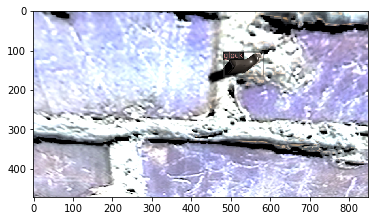

In [16]:
smpl = np.random.choice(test_dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_test_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

<class 'numpy.ndarray'> (628, 1131, 3)
<class 'numpy.ndarray'> (628, 1131, 3)
[800, 800]
<class 'numpy.ndarray'> (628, 1131, 3)
<class 'numpy.ndarray'> (628, 1131, 3)
[800, 800]
<class 'numpy.ndarray'> (628, 1131, 3)
<class 'numpy.ndarray'> (628, 1131, 3)
[800, 800]


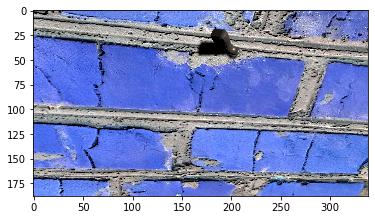

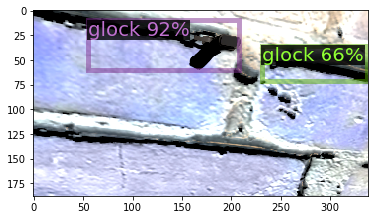

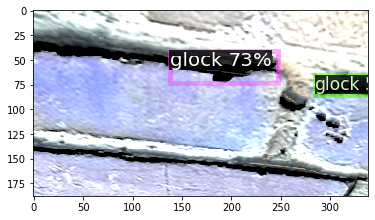

In [18]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(test_dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_test_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]
[800, 800]


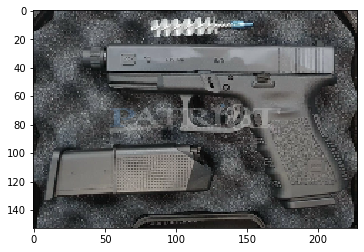

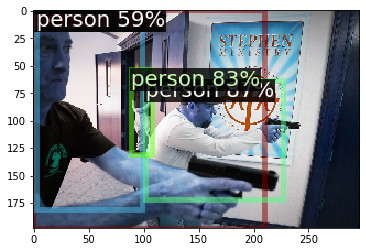

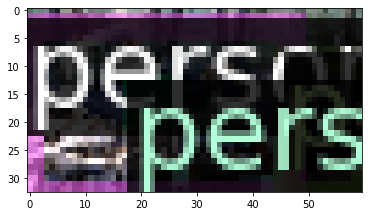

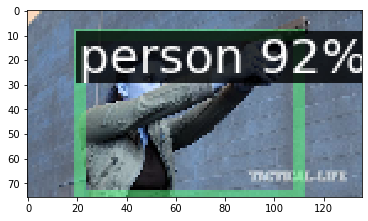

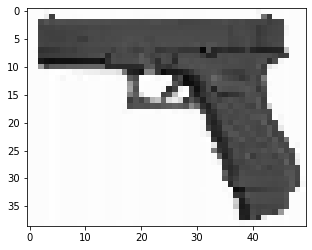

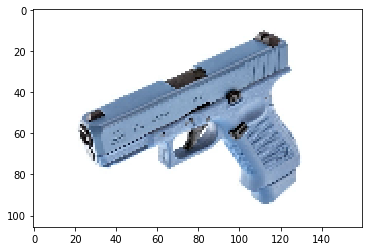

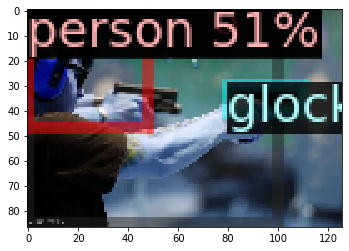

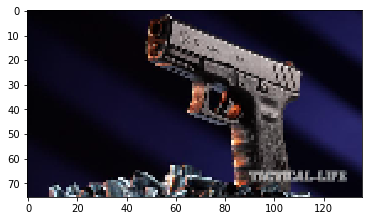

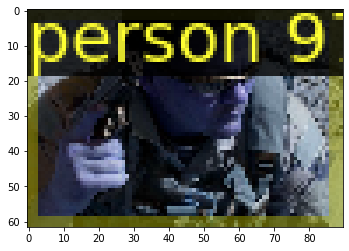

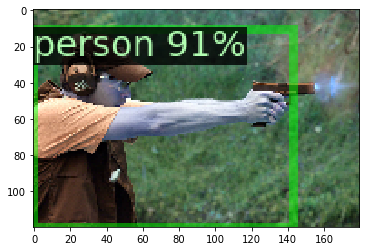

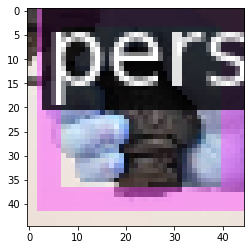

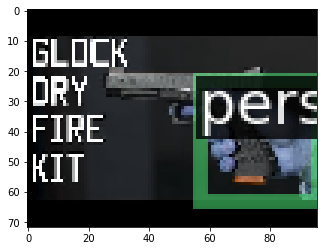

In [19]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/home/m/Pulpit/klocki"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    #im = cv2.resize(im, (1131,597))
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.2, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())